<a href="https://colab.research.google.com/github/MateoOrtiz001/Laboratory-LSTM-GRU-Inflation/blob/main/Laboratorio_LSTM_GRU_Inflacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio LSTM-GRU

En el presente cuaderno presentaremos las redes recurrentes LSTM y GRU. Como motivación se aplicará al problema de la predicción de la inflación mensual en Colombia.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import StandardScaler

## Dataset
El dataset seleccionado corresponde al histórico del porcentaje mensual de la inflación en Colombia presentado por el banco de la república (disponible en su [base de datos](https://suameca.banrep.gov.co/buscador-de-series/#/)).

Primero vamos a cargar el dataset directamente desde el repositorio.

In [2]:
!git clone https://github.com/MateoOrtiz001/Laboratory-LSTM-GRU-Inflation
sys.path.append('Laboratory-LSTM-GRU-Inflation')
from utils import *
data = pd.read_excel('Laboratory-LSTM-GRU-Inflation/dataset/Datos-Inflacion.xlsx', decimal=',')
data.head()

Cloning into 'Laboratory-LSTM-GRU-Inflation'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 88.08 KiB | 1.80 MiB/s, done.
Resolving deltas: 100% (8/8), done.


,Fecha,Inflacion
0,NaN,NaN
1,31/07/1955,-0.87
2,31/08/1955,-0.01
3,30/09/1955,0.84
4,31/10/1955,0.77


El conjunto de datos contiene el historial de inflación desde 1955. En primer lugar, recortaremos la información a partir del año 2000, ya que los patrones observados en los registros más antiguos difieren de los de las últimas tres décadas. Posteriormente, prepararemos las columnas para estandarizar los tipos de datos.

In [3]:
# Convertimos la columna 'Fecha' a objeto datetime y la seleccionamos como índice
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y', errors='coerce')
data = data.dropna(subset=['Fecha']).set_index('Fecha')

# Eliminamos filas sin datos en la columna 'Inflacion'
data = data.dropna(subset=['Inflacion']).copy()

# Dividimos los datos de la inflacion sobre 100 para tener el porcentaje
data['Inflacion'] = pd.to_numeric(data['Inflacion'], errors='coerce') / 100

# Filtramos los datos desde 2000
data = data[data.index >= '2000-01-01']
display(data.head())

,Inflacion
Fecha,
2000-01-31,0.0825
2000-02-29,0.0889
2000-03-31,0.0973
2000-04-30,0.0996
2000-05-31,0.1000


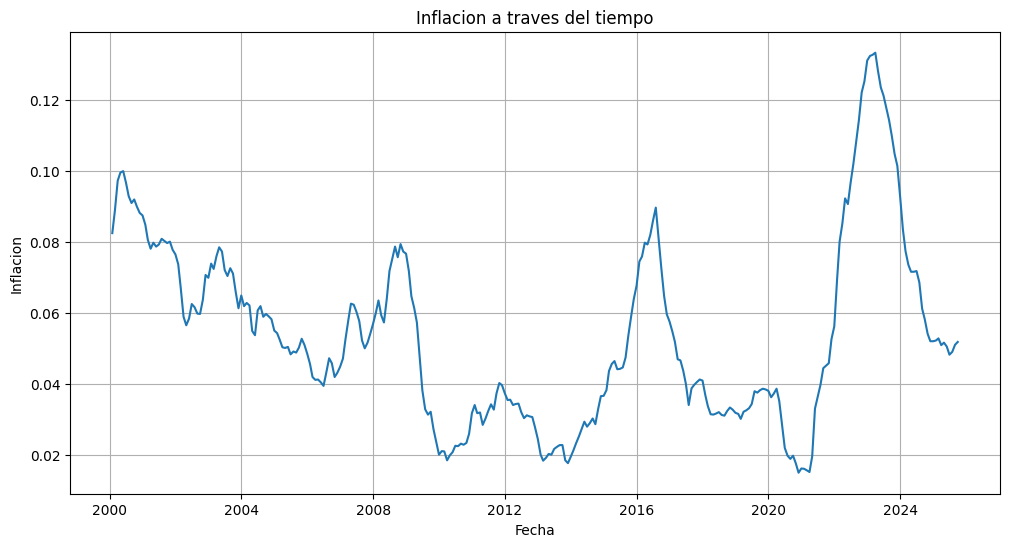

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(data['Inflacion'])
plt.title('Inflacion a traves del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Inflacion')
plt.grid(True)
plt.show()

### Secuencia de ventanas
Para entrenar un modelo recurrente es necesario transformar la serie temporal en un conjunto de secuencias de entrada y salida.

Este proceso se conoce como **sliding window** o ventana deslizante, y consiste en recorrer los datos históricos con una ventana de longitud fija que captura una secuencia de valores pasados (entrada), asociándola con uno o varios valores futuros (salida).

Por ejemplo, si tenemos la siguiente serie temporal:

$$ [x_1,x_2,\dotsb, x_t  ]$$

y tenemos una ventana ```n_steps_in = 3``` para retornar un solo valor ```n_steps_out = 1```. Entonces las muestras de entrenamiento son de la forma:

* Entrada: $[x_1,x_2,x_3]$. Salida: $x_4$
* Entrada: $[x_2,x_3,x_4]$. Salida: $x_5$.
* Entrada: $[x_{i-1},x_i,x_{i+1}]$. Salida: $x_{i+2}$.

In [5]:
def create_sequences(data, n_steps_in, n_steps_out):
    """
    Crea secuencias de entrada-salida para LSTM usando sliding window
    Argumentos:
    data -- array 1D con los datos de inflación
    n_steps_in -- número de pasos temporales de entrada (ventana)
    n_steps_out -- número de pasos a predecir (tamaño de la salida).

    Retorna:
    X -- array con secuencias de entrada, shape (n_samples, n_steps_in)
    Y -- array con valores objetivo, shape (n_samples, n_steps_out)
    """
    X, Y = [], []
    ### START CODE HERE ###
    # Recorremos la serie aplicando la ventana deslizante
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        # Secuencia de entrada: ventana de n_steps_in valores. X.append(...)
        X.append(data[i:(i + n_steps_in)])
        # Valor objetivo: el siguiente valor después de la ventana. Y.append(...)
        Y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])
    ### END CODE HERE ###

    return np.array(X), np.array(Y)

In [6]:
# Tester de la funcion create_sequences
# Fijamos una semilla para los test
np.random.seed(42)
# Generamos 20 datos aleatorios
random_data = np.random.rand(20)

# Imprimimos los datos generados
print("Datos aleatorios generados:")
print(random_data)

# Definimos los parámetros
n_steps_in = [5,3,6,3]
n_steps_out = [2,1,4,3]

# Iteramos sobre los parametros
for n_steps_in_value, n_steps_out_value in zip(n_steps_in, n_steps_out):
  X, Y = create_sequences(random_data, n_steps_in_value, n_steps_out_value)
  # Imprimimos solo el primer caso
  if n_steps_in_value == 5:
    print("\nPrimer secuencia de entrada (X):")
    print(X[0])
    print("\nPrimer secuencia de salida (Y):")
    print(Y[0])
  # Verificamos el número de secuencias esperadas
  expected_num_sequences = len(random_data) - n_steps_in_value - n_steps_out_value + 1
  assert len(X) == expected_num_sequences, f"Expected {expected_num_sequences} sequences, but got {len(X)}"
  assert len(Y) == expected_num_sequences, f"Expected {expected_num_sequences} sequences, but got {len(Y)}"
  # Verificamos el shape de las secuencias
  assert X.shape == (expected_num_sequences, n_steps_in_value), f"Expected X shape {(expected_num_sequences, n_steps_in_value)}, but got {X.shape}"
  assert Y.shape == (expected_num_sequences, n_steps_out_value), f"Expected Y shape {(expected_num_sequences, n_steps_out_value)}, but got {Y.shape}"
  # Verificamos el primer elemento de las secuencias
  assert np.array_equal(X[0], random_data[:n_steps_in_value]), f"First input sequence is incorrect. Expected {random_data[:n_steps_in_value]}, but got {X[0]}"
  assert np.array_equal(Y[0], random_data[n_steps_in_value:n_steps_in_value + n_steps_out_value]), f"First output sequence is incorrect. Expected {random_data[n_steps_in_value:n_steps_in_value + n_steps_out_value]}, but got {Y[0]}"

print('\033[92mTest Aprobado\033[0m')

Datos aleatorios generados:
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914]

Primer secuencia de entrada (X):
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]

Primer secuencia de salida (Y):
[0.15599452 0.05808361]
Test Aprobado


**Datos esperados:**

Primer secuencia de entrada (X):
```
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
```

Primer secuencia de salida (Y):
```
[0.15599452 0.05808361]
```

### Forma de los datos

*Pista: puede ser útil revisar la función ```reshape()``` en [NumPy](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)*


In [7]:
def reshape_data(X, Y):
    """
    Transforma datos al formato requerido para la LSTM y la red GRU.

    LSTM espera:
    - X: shape (n_x, m, T_x) donde:
        n_x = número de features
        m = batch size (número de muestras)
        T_x = longitud de secuencia temporal
    - Y: shape (n_y, m, 1) donde:
        n_y = número de salidas
        m = batch size

    Argumentos:
    X -- array shape (m, T_x)
    Y -- array shape (m, n_steps_out)

    Retorna:
    X_reshaped -- array shape (n_x, m, T_x)
    Y_reshaped -- array shape (n_y, m, 1)
    """
    ### START CODE HERE ###
    X_reshaped = X.reshape(1, X.shape[0], X.shape[1]) # X: de (m, T_x) a (1, m, T_x)
    Y_reshaped = Y.T.reshape(Y.shape[1], -1, 1)     # Y: de (m, n_steps_out) a (n_steps_out, m, 1)
    ### END CODE HERE ###

    return X_reshaped, Y_reshaped

In [8]:
# Tester de la funcion reshape_for_lstm
# Fijamos una semilla para los test para reproducibilidad
np.random.seed(42)

# Definimos diferentes tamaños de ventana y pasos de salida para probar
test_params = [
    (10, 3),  # T_x=10, n_steps_out=3
    (5, 1),   # T_x=5, n_steps_out=1
    (15, 5)   # T_x=15, n_steps_out=5
]

for n_steps_in, n_steps_out in test_params:
    # Generamos datos de ejemplo con un número arbitrario de muestras (m)
    m = 25 # Número de muestras
    X_original = np.random.rand(m, n_steps_in)
    Y_original = np.random.rand(m, n_steps_out)

    # Aplicamos la función de reshape
    X_reshaped, Y_reshaped = reshape_data(X_original, Y_original)

    # Imprimimos las formas originales y transformadas para el primer caso
    if n_steps_in == 10:
        print(f"Probando con n_steps_in={n_steps_in}, n_steps_out={n_steps_out}, m={m}")
        print("Shape inicial de X:", X_original.shape)
        print("Reshape de X:", X_reshaped.shape)
        print("Shape inicial de Y:", Y_original.shape)
        print("Reshape de Y:", Y_reshaped.shape)
        print("-" * 20)


    # Verificamos las formas transformadas
    expected_X_shape = (1, m, n_steps_in)
    expected_Y_shape = (n_steps_out, m, 1)

    assert X_reshaped.shape == expected_X_shape, f"Expected X shape {expected_X_shape}, but got {X_reshaped.shape}"
    assert Y_reshaped.shape == expected_Y_shape, f"Expected Y shape {expected_Y_shape}, but got {Y_reshaped.shape}"

    # Verificamos el contenido (comparando elementos seleccionados)
    # X_reshaped[0, :, i] debería ser igual a X_original[:, i]
    for i in range(n_steps_in):
        assert np.array_equal(X_reshaped[0, :, i], X_original[:, i]), f"Content mismatch in X at step {i}"

    # Y_reshaped[i, :, 0] debería ser igual a Y_original[:, i]
    for i in range(n_steps_out):
        assert np.array_equal(Y_reshaped[i, :, 0], Y_original[:, i]), f"Content mismatch in Y at step {i}"


print('\033[92mTest Aprobado\033[0m')

Probando con n_steps_in=10, n_steps_out=3, m=25
Shape inicial de X: (25, 10)
Reshape de X: (1, 25, 10)
Shape inicial de Y: (25, 3)
Reshape de Y: (3, 25, 1)
--------------------
Test Aprobado


### Preparación del conjunto de entrenamiento/prueba
Primero normalizamos los datos. Posteriormente creamos las secuencias con la función definida anteriormente.

In [9]:
# Utilizamos normalización con escala estándar
scaler = StandardScaler()
inflation_scaled = scaler.fit_transform(data[['Inflacion']].values)
# Configuración de ventana temporal
n_steps_in = 12  # Usar 12 meses previos para predecir el siguiente
n_steps_out = 1  # Predecir 1 mes adelante

X_seq, y_seq = create_sequences(inflation_scaled, n_steps_in, n_steps_out)

Ahora dividimos el conjunto de secuencias en 80% para entrenamiento y el 20% para prueba.
Además, para entrenar los modelos con Keras, necesitamos mantener la misma forma.

In [10]:
# Entrenamiento con el dataset
train_size = int(len(X_seq) * 0.8)  # 80% entrenamiento, 20% test

X_train_keras = X_seq[:train_size]
y_train_keras = y_seq[:train_size]
X_test_keras = X_seq[train_size:]
y_test_keras = y_seq[train_size:]

Finalmente cambiamos la forma de los datos para el entrenamiento para los modelos hechos en NumPy.

In [11]:
X_train, y_train = reshape_data(X_train_keras, y_train_keras)
X_test, y_test = reshape_data(X_test_keras, y_test_keras)

## Primer Modelo: LSTM

El primer modelo a implementar será la LSTM.

### Celda del Foward Pass

In [12]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: lstm_cell_forward

def lstm_cell_forward(xt, h_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    h_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_h, n_h + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wu -- Weight matrix of the update gate, numpy array of shape (n_h, n_h + n_x)
                        bu -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_h, n_h + n_x)
                        bc --  Bias of the first "tanh", numpy array of shape (n_h, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_h, n_h + n_x)
                        bo --  Bias of the output gate, numpy array of shape (n_h, 1)


    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)

    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the cell state (memory)
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"] # forget gate weight
    bf = parameters["bf"]
    Wu = parameters["Wu"] # update gate weight (notice the variable name)
    bu = parameters["bu"] # (notice the variable name)
    Wc = parameters["Wc"] # candidate value weight
    bc = parameters["bc"]
    Wo = parameters["Wo"] # output gate weight
    bo = parameters["bo"]


    # Retrieve dimensions from shapes of xt
    n_x, m = xt.shape
    n_a, _ = h_prev.shape # Assuming a_prev shape is (n_a, m)

    ### START CODE HERE ###
    # Concatenate a_prev and xt (≈1 line)
    concat = np.concatenate((h_prev,xt))

    # Compute values for ft, ut, cct, c_next, ot, a_next using the formulas given figure (4) (≈6 lines)
    ft = sigmoid(np.dot(Wf,concat) + bf)
    ut = sigmoid(np.dot(Wu,concat) + bu)
    cct = np.tanh(np.dot(Wc,concat) + bc)
    c_next = ft * c_prev + ut * cct
    ot = sigmoid(np.dot(Wo,concat) + bo)
    h_next = ot * np.tanh(c_next)

    ### END CODE HERE ###

    # store values needed for backward propagation in cache
    cache = (h_next, c_next, h_prev, c_prev, ft, ut, cct, ot, xt, parameters)

    return h_next, c_next, cache

### Forward Pass

In [13]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: lstm_forward

def lstm_forward(x, h0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (4).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x) # Adjusted shape
    c -- The value of the cell state, numpy array of shape (n_a, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []

    ### START CODE HERE ###
    Wy = parameters['Wy'] # saving parameters['Wy'] in a local variable in case students use Wy instead of parameters['Wy']
    by = parameters['by'] # saving parameters['by']

    # Retrieve dimensions from shapes of x and parameters['Wy'] (≈2 lines)
    n_x, m, T_x = x.shape
    n_y, n_h = Wy.shape

    # initialize "a", "c" and "y" with zeros (≈3 lines)
    h = np.zeros((n_h,m,T_x))
    c = np.zeros((n_h,m,T_x))
    y = np.zeros((n_y,m,1)) # Adjusted shape

    # Initialize a_next and c_next (≈2 lines)
    h_next = h0
    c_next = np.zeros((n_h,m))

    # loop over all time-steps
    for t in range(T_x): # Loop through all timesteps
        # Get the 2D slice 'xt' from the 3D input 'x' at time step 't'
        xt = x[:,:,t]
        # Update next hidden state, next memory state, compute the prediction, get the cache (≈1 line)
        h_next, c_next, cache = lstm_cell_forward(xt,h_next,c_next,parameters)

        # Save the value of the new "next" hidden state in a (≈1 line)
        h[:,:,t] = h_next
        # Save the value of the next cell state (≈1 line)
        c[:,:,t]  = c_next
        # Append the cache into caches (≈1 line)
        caches.append(cache)
    ### END CODE HERE ###
    y = np.dot(Wy,h[:,:,-1]) + by
    # store values needed for backward propagation in cache
    caches = (caches, x)

    return h, y, c, caches

### Celda del Backward Pass

In [14]:
# UNGRADED FUNCTION: lstm_cell_backward

def lstm_cell_backward(dh_next, dc_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (h_next, c_next, h_prev, c_prev, ft, ut, cct, ot, xt, parameters) = cache

    ### START CODE HERE ###
    # Retrieve dimensions from xt's and a_next's shape (≈2 lines)
    n_x, m = xt.shape
    n_h, m = h_next.shape

    # Compute gates related derivatives. Their values can be found by looking carefully at equations (7) to (10) (≈4 lines)
    dot = dh_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (dc_next * ut + ot * (1 - np.power(np.tanh(c_next),2)) * ut * dh_next) * (1 - np.power(cct,2))
    dut = (dc_next * cct + ot * (1 - np.power(np.tanh(c_next),2)) * cct * dh_next) * ut * (1 - ut)
    dft = (dc_next * c_prev + ot * (1 - np.power(np.tanh(c_next),2)) * c_prev * dh_next) * ft * (1 - ft)

    # Compute parameters related derivatives. Use equations (11)-(18) (≈8 lines)
    concat_t = np.concatenate((h_prev,xt),axis=0).T
    dWf = np.dot(dft,concat_t)
    dWu = np.dot(dut,concat_t)
    dWc = np.dot(dcct,concat_t)
    dWo = np.dot(dot,concat_t)
    dbf = np.sum(dft,axis=1,keepdims=True)
    dbu = np.sum(dut,axis=1,keepdims=True)
    dbc = np.sum(dcct,axis=1,keepdims=True)
    dbo = np.sum(dot,axis=1,keepdims=True)

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (19)-(21). (≈3 lines)
    dh_prev = np.dot(parameters["Wf"][:,:n_h].T,dft) + np.dot(parameters["Wu"][:,:n_h].T,dut) + np.dot(parameters["Wc"][:,:n_h].T,dcct) + np.dot(parameters["Wo"][:,:n_h].T, dot)
    dc_prev = dc_next * ft + ot * (1- np.power(np.tanh(c_next),2)) * ft * dh_next
    dxt = np.dot(parameters["Wf"][:,n_h:].T,dft) + np.dot(parameters["Wu"][:,n_h:].T,dut) + np.dot(parameters["Wc"][:,n_h:].T,dcct) + np.dot(parameters["Wo"][:,n_h:].T, dot)
    ### END CODE HERE ###



    # Save gradients in dictionary
    gradients = {"dxt": dxt, "dh_prev": dh_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWu": dWu,"dbu": dbu,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

### Backward Pass

In [15]:
# UNGRADED FUNCTION: lstm_backward

def lstm_backward(dh, caches, m_batch):

    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)
    m_batch -- The size of the minibatch, integer

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (h1, c1, h0, c0, f1, u1, cc1, o1, x1, parameters) = caches[0]

    ### START CODE HERE ###
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_h, m, T_x = dh.shape
    n_x, m = x1.shape

    # initialize the gradients with the right sizes (≈12 lines)
    dx = np.zeros((n_x,m,T_x))
    dh0 = np.zeros((n_h,m))
    dh_prevt =  np.zeros((n_h,m))
    dc_prevt =  np.zeros((n_h,m))
    dWf = np.zeros((n_h,n_h + n_x))
    dWu = np.zeros((n_h,n_h + n_x))
    dWc = np.zeros((n_h,n_h + n_x))
    dWo = np.zeros((n_h,n_h + n_x))
    dbf = np.zeros((n_h,1))
    dbu = np.zeros((n_h,1))
    dbc = np.zeros((n_h,1))
    dbo = np.zeros((n_h,1))

    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward. Choose wisely the "da_next" (same as done for Ex 6).
        gradients = lstm_cell_backward(dh[:,:,t]+dh_prevt,dc_prevt,caches[t])
        # Store or add the gradient to the parameters' previous step's gradient
        dh_prevt = gradients["dh_prev"]
        dc_prevt = gradients["dc_prev"]
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWu += gradients["dWu"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbu += gradients["dbu"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    dh0 = dh_prevt

    ### END CODE HERE ###
    dWf /= m_batch; dWu /= m_batch; dWc /= m_batch; dWo /= m_batch
    dbf /= m_batch; dbu /= m_batch; dbc /= m_batch; dbo /= m_batch
    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "dh0": dh0, "dWf": dWf,"dbf": dbf, "dWu": dWu,"dbu": dbu,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

### Inicialización de parámetros

Para la inicialización de los parámetros necesitamos obsevar que para $W_u,W_f,W_o$ y $W_c$ tenemos como función de activación la función $\tanh$ y para la salida $W_y$ se activa con la función $\sigma$. Esto con el objetivo de evitar problemas numéricos como la explosión o el desvanecimiento de gradientes.

Para ambas funciones vamos a considerar la inicialización *Xavier* (1). Esto corresponde a tomar una distribución gausiana con media $0$ y desviación estándar

$$ \sigma = \sqrt{\frac{2}{N}}\hspace{2cm}(1) $$

en donde $N$ es la dimensión de entrada de cada matriz de pesos $W$.

Mientras que para los bias $b$ inicializaremos con vectores en blanco.


In [16]:
def initialize_LSTM_parameters(n_h, n_x, n_y):
    """
    Inicializa los parámetros de la LSTM con Xavier initialization,
    utilizando la fórmula (1)

    Arguments:
    n_a -- número de unidades en el hidden state
    n_x -- número de features de entrada
    n_y -- número de features de salida

    Returns:
    parameters -- diccionario con los parámetros inicializados
    """
    np.random.seed(1)

    parameters = {}
    ### START CODE HERE ###
    parameters['Wf'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
    parameters['bf'] = np.zeros((n_h, 1))

    parameters['Wu'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
    parameters['bu'] = np.zeros((n_h, 1))

    parameters['Wc'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
    parameters['bc'] = np.zeros((n_h, 1))

    parameters['Wo'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
    parameters['bo'] = np.zeros((n_h, 1))

    parameters['Wy'] = np.random.randn(n_y, n_h) * np.sqrt(2.0 / n_h)
    parameters['by'] = np.zeros((n_y, 1))

    ### END CODE HERE ###
    return parameters


In [17]:
def model_lstm_adam(X, Y, n_h, learning_rate=0.001, mini_batch_size=32,
                    beta1=0.9, beta2=0.999, epsilon=1e-8,
                    num_epochs=1000, print_cost=True):
    """
    Entrena una LSTM desde cero con Adam y minibatches.

    Arguments:
    X -- datos de entrada, numpy array (n_x, m, T_x)
    Y -- datos objetivo, numpy array (n_y, m, 1)
    n_a -- número de unidades del estado oculto
    learning_rate -- tasa de aprendizaje Adam
    mini_batch_size -- tamaño de minibatch
    num_epochs -- número de épocas
    """

    n_x, m, T_x = X.shape
    n_y, _, _ = Y.shape # Y shape is (n_y, m, 1)

    # Inicialización
    parameters = initialize_LSTM_parameters(n_h, n_x, n_y)
    v, s = initialize_adam(parameters)
    seed = 10
    costs = []
    t = 0  # contador de pasos de Adam

    for epoch in range(num_epochs):
        seed += 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        epoch_cost = 0

        for minibatch_X, minibatch_Y in minibatches:
            # Inicialización del hidden state
            m_batch = minibatch_X.shape[1]
            h0 = np.zeros((n_h, m_batch))

            # Forward pass
            h, y_pred, c, caches = lstm_forward(minibatch_X, h0, parameters) # y_pred shape (n_y, m, 1)

            # Costo (MSE) - Needs to compare y_pred (n_y, m, 1) with minibatch_Y (n_y, m, 1)
            # We need to compare the last prediction of the sequence with the target

            cost = compute_cost(y_pred, minibatch_Y.squeeze(axis=2)) # Compare last prediction with target

            # Backward pass
            # Initialize upstream gradients for hidden states and cell states
            dh = np.zeros_like(h) # shape (n_a, m_batch, T_x)
            dc = np.zeros_like(c) # shape (n_a, m_batch, T_x)

            # Calculate gradient of the cost w.r.t the output layer at the last timestep
            # Cost function is MSE: 0.5 * sum((y_pred - y_true)^2) / m
            # dCost/dy_pred = (y_pred - y_true) / m
            # y_pred is Wy @ a_next + by passed through sigmoid.
            # dCost/dWy = dCost/dy_pred * dy_pred/d(Wy @ a_next + by) * d(Wy @ a_next + by)/dWy
            # dCost/dby = dCost/dy_pred * dy_pred/d(Wy @ a_next + by) * d(Wy @ a_next + by)/dby
            # Assuming sigmoid output: dy_pred/d(z) = y_pred * (1 - y_pred) where z = Wy @ a_next + by

            # Gradient of cost w.r.t the output prediction at the last timestep
            dcost_dy_pred_last = (y_pred - minibatch_Y.squeeze(axis=2)) / m_batch # shape (n_y, m_batch)

            # Gradient of cost w.r.t the argument of the sigmoid at the last timestep (zt)
            zt_last = np.dot(parameters['Wy'], h[:,:,-1]) + parameters['by'] # shape (n_y, m_batch)

            dcost_dzt_last = np.squeeze(dcost_dy_pred_last)
            if dcost_dzt_last.ndim == 1:
                dcost_dzt_last = dcost_dzt_last.reshape(1, -1)

            # Gradiente hacia el último estado oculto
            dh[:, :, -1] = np.dot(parameters['Wy'].T, dcost_dzt_last)

            # Backpropagate through the LSTM sequence
            # Need to pass da[:,:,-1] to lstm_backward as the initial da_next
            grads = lstm_backward(dh, caches, m_batch)

            # Add gradients for Wy and by (calculated from the output layer)
            # dCost/dWy = dCost/dzt * dzt/dWy = dcost_dzt_last @ a_next.T
            grads['dWy'] = np.dot(dcost_dzt_last, h[:,:,-1].T) # shape (n_y, n_a)
            # dCost/dby = dCost/dzt * dzt/dby = sum(dcost_dzt_last, axis=1, keepdims=True)
            grads['dby'] = np.sum(dcost_dzt_last, axis=1, keepdims=True) # shape (n_y, 1)

            # Clip gradients
            grads = clip_gradients(grads, 5.0)

            # Update Adam
            t += 1
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t,
                                                        learning_rate, beta1, beta2, epsilon)

            epoch_cost += cost / len(minibatches)

        # Guardar costo
        if print_cost:
            print(f"Cost after epoch {epoch}: {epoch_cost:.6f}")
            costs.append(epoch_cost)

    # Graficar costos
    plot_training(costs)


    return parameters

Cost after epoch 0: 0.248340
Cost after epoch 1: 0.146889
Cost after epoch 2: 0.086468
Cost after epoch 3: 0.068964
Cost after epoch 4: 0.068650
Cost after epoch 5: 0.057628
Cost after epoch 6: 0.048036
Cost after epoch 7: 0.045528
Cost after epoch 8: 0.042041
Cost after epoch 9: 0.038196
Cost after epoch 10: 0.033316
Cost after epoch 11: 0.030880
Cost after epoch 12: 0.028756
Cost after epoch 13: 0.026273
Cost after epoch 14: 0.024347
Cost after epoch 15: 0.023649
Cost after epoch 16: 0.023041
Cost after epoch 17: 0.022080
Cost after epoch 18: 0.020866
Cost after epoch 19: 0.020833
Cost after epoch 20: 0.019154
Cost after epoch 21: 0.018897
Cost after epoch 22: 0.018301
Cost after epoch 23: 0.018196
Cost after epoch 24: 0.017097
Cost after epoch 25: 0.016239
Cost after epoch 26: 0.016156
Cost after epoch 27: 0.015505
Cost after epoch 28: 0.015166
Cost after epoch 29: 0.014799
Cost after epoch 30: 0.014432
Cost after epoch 31: 0.014170
Cost after epoch 32: 0.013801
Cost after epoch 33:

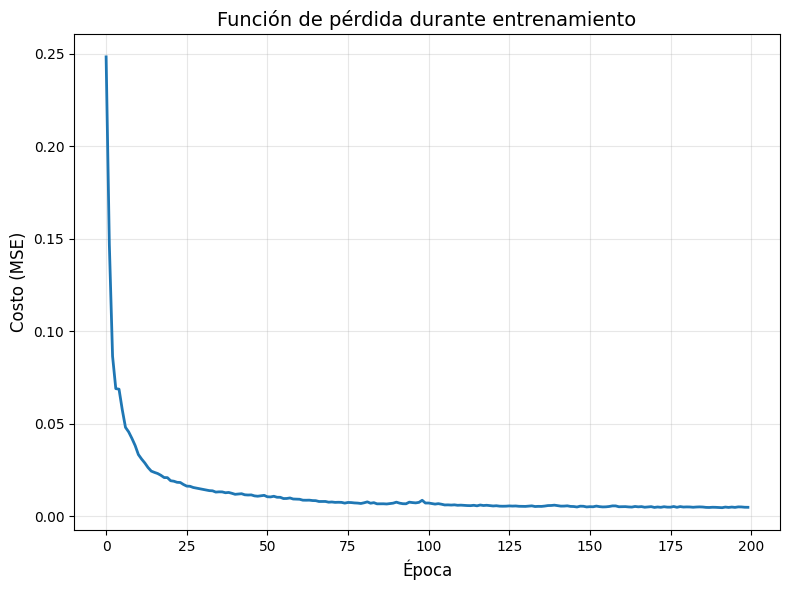

In [18]:
modeloLSTM = model_lstm_adam(
    X_train,
    y_train,
    n_h= 78,                # número de unidades del estado oculto
    learning_rate=0.001,  # tasa de aprendizaje
    mini_batch_size=64,   # tamaño del minibatch (puedes ajustar)
    num_epochs=200,        # número de épocas
    print_cost=True       # mostrar el costo
)


In [19]:
def predict_lstm(x, parameters):
    """
    Realiza una sola pasada hacia adelante de la LSTM para predecir un valor.

    Argumentos:
    x -- Datos de entrada para la predicción, shape (n_x, m, T_x)
    parameters -- Diccionario de Python con los parámetros entrenados (Wf, bf, Wi, bi, ...)

    Retorna:
    y_pred -- La predicción del modelo.
    """
    # Extraer dimensiones de la entrada
    n_x, m, T_x = x.shape
    n_y, n_h = parameters["Wy"].shape

    # Inicializar estados ocultos y de celda
    h_next = np.zeros((n_h, m))
    c_next = np.zeros((n_h, m))

    # Bucle a través del tiempo
    for t in range(T_x):
        xt = x[:, :, t]
        h_next, c_next, _ = lstm_cell_forward(xt, h_next, c_next, parameters)
    y_pred = np.dot(parameters['Wy'], h_next) + parameters['by']
    return y_pred

### Predicción
Ahora veamos la predicción del modelo para los doce meses próximos del dataset.

In [20]:
# Tomamos la última ventana de datos conocida del conjunto de prueba
current_window = X_test[:, -1:, :]

# Lista para guardar las predicciones
future_LSTM_predictions_scaled = []

# Bucle para predecir 12 pasos hacia adelante
for i in range(12):
    # Hacer la predicción
    next_step_pred_scaled = predict_lstm(current_window, modeloLSTM)

    # Guardar la predicción
    future_LSTM_predictions_scaled.append(next_step_pred_scaled.flatten()[0])

    # Actualizar la ventana: eliminar el valor más antiguo y añadir la nueva predicción
    # El reshape es crucial para mantener la forma (1, 1, T_x)
    new_window_values = np.append(current_window.flatten()[1:], next_step_pred_scaled.flatten())
    current_window = new_window_values.reshape(1, 1, n_steps_in)

# 4. Des-normalizar las predicciones para verlas en la escala original
future_LSTM_predictions = scaler.inverse_transform(np.array(future_LSTM_predictions_scaled).reshape(-1, 1))

print("Predicciones de inflación para los próximos 12 meses:")
print(future_LSTM_predictions.flatten())

Predicciones de inflación para los próximos 12 meses:
[0.05198741 0.05274309 0.05325141 0.05371414 0.05426542 0.0549928
 0.05594355 0.05709669 0.05843853 0.05993749 0.06157044 0.0633656 ]


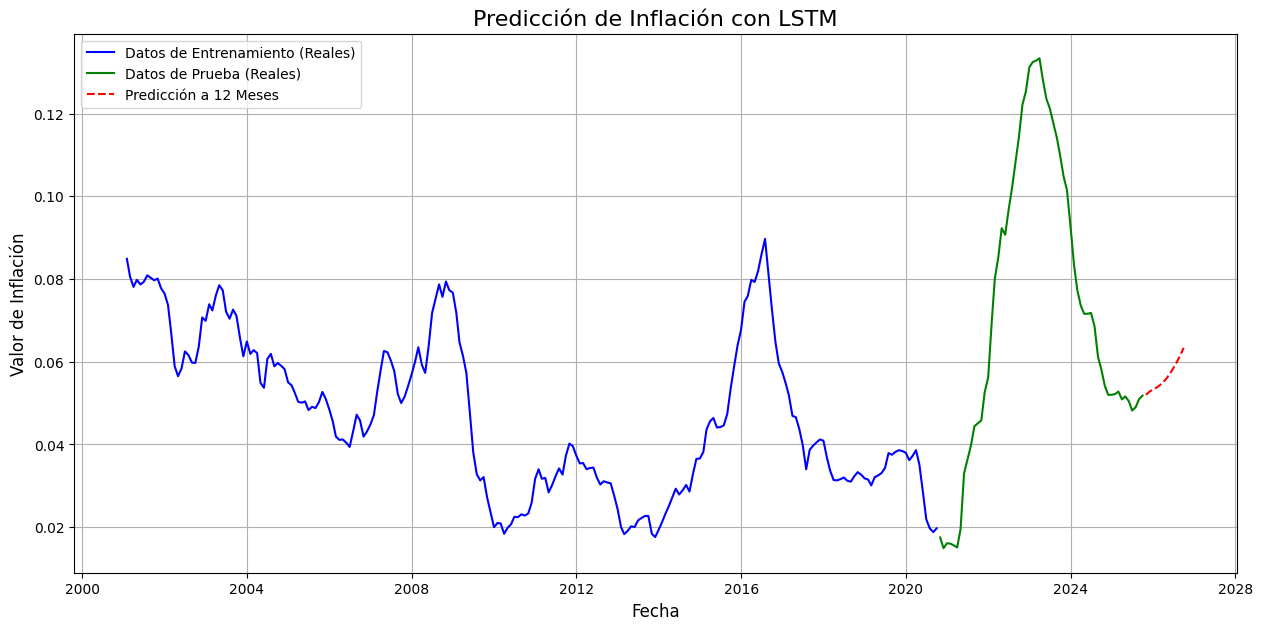

In [21]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=13, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, future_LSTM_predictions.flatten(), label='Predicción a 12 Meses', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con LSTM', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Implementación con Keras
Ahora vamos a realizar una comparación entre nuestro modelo y uno creado con Keras.

Primero cargamos las librerias necesarias.

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [23]:
modeloLSTM_Keras = Sequential()
modeloLSTM_Keras.add(LSTM(units=78, input_shape=(X_train.shape[1], 1)))
modeloLSTM_Keras.add(Dense(1))

modeloLSTM_Keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
historyLSTM = modeloLSTM_Keras.fit(X_train_keras, y_train_keras, epochs=200, batch_size=64, verbose=1)

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6699
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4260
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2267
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1825
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1816
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1548
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1310
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1349
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1229
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1215
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1112
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0949
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0943
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0855
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0905
Epoch 16/200
4/4 ━━━━━━━━━━━━━━

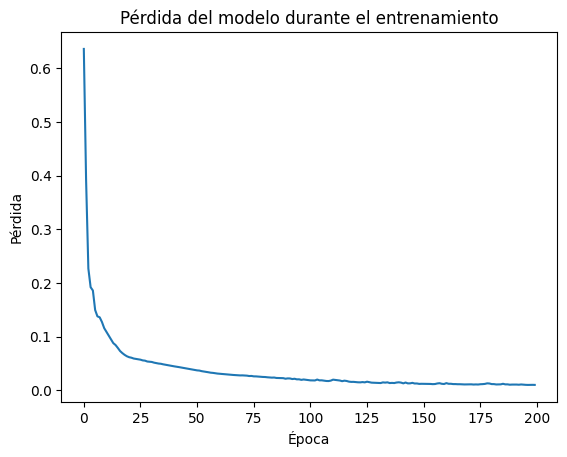

In [24]:
# Graficar la función de pérdida
plt.plot(historyLSTM.history['loss'])
plt.title('Pérdida del modelo durante el entrenamiento')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()

In [47]:
# Predicción para el próximo año
seq_lenght = 12 # This should be n_steps_in, which is 12

# Take the last sequence from the scaled data for the initial prediction
current_window_keras = inflation_scaled[-n_steps_in:].reshape(1, n_steps_in, 1)

# List to store the 12-month predictions
future_LSTM_keras_predictions_scaled = []

for _ in range(12):
    # Make a prediction for the next step
    next_step_pred_scaled = modeloLSTM_Keras.predict(current_window_keras, verbose=0)

    # Store the prediction
    future_LSTM_keras_predictions_scaled.append(next_step_pred_scaled[0, 0])

    # Update the window: remove the oldest value and add the new prediction
    # Ensure current_window_keras remains (1, n_steps_in, 1)
    new_window_values = np.append(current_window_keras.flatten()[1:], next_step_pred_scaled.flatten())
    current_window_keras = new_window_values.reshape(1, n_steps_in, 1)

# Denormalize all 12 predictions
future_LSTM_keras = scaler.inverse_transform(np.array(future_LSTM_keras_predictions_scaled).reshape(-1, 1))

print("Predicciones de inflación para los próximos 12 meses con Keras:")
print(future_LSTM_keras.flatten())

Predicciones de inflación para los próximos 12 meses con Keras:
[0.05229961 0.05277014 0.0533602  0.05409373 0.05496761 0.05598883
 0.05712501 0.05838968 0.05976547 0.06119021 0.06264556 0.06413776]


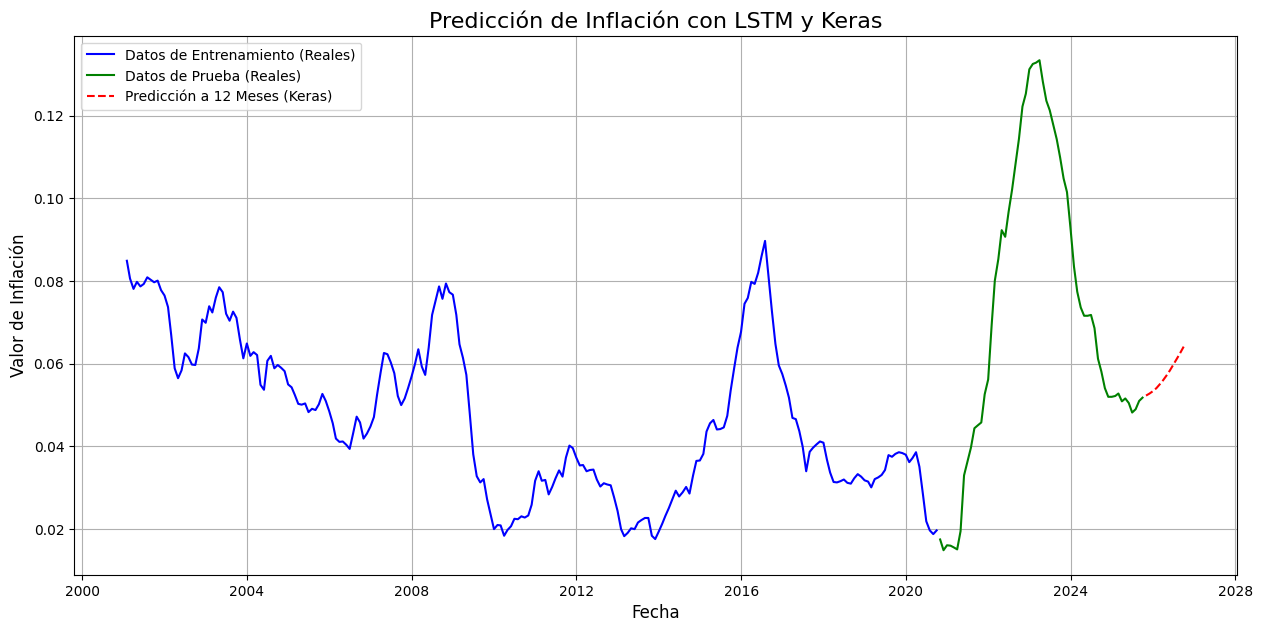

In [48]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=13, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, future_LSTM_keras.flatten(), label='Predicción a 12 Meses (Keras)', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con LSTM y Keras', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## GRU

In [27]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: lstm_cell_forward

def gru_cell_forward(xt, h_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wu -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bu -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo --  Bias of the output gate, numpy array of shape (n_a, 1)


    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)

    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the cell state (memory)
    """

    # Retrieve parameters from "parameters"
    Wu = parameters["Wu"] # forget gate weight
    bu = parameters["bu"]
    Wc = parameters["Wc"] # update gate weight (notice the variable name)
    bc = parameters["bc"] # (notice the variable name)
    Wr = parameters["Wr"] # candidate value weight
    br = parameters["br"]


    # Retrieve dimensions from shapes of xt
    n_x, m = xt.shape
    n_h, _ = h_prev.shape # Assuming a_prev shape is (n_a, m)

    ### START CODE HERE ###
    # Concatenate a_prev and xt (≈1 line)
    concat = np.concatenate((h_prev,xt))

    # Compute values for ft, ut, cct, c_next, ot, a_next using the formulas given figure (4) (≈6 lines)
    ut = sigmoid(np.dot(Wu,concat) + bu)
    rt = sigmoid(np.dot(Wr,concat) + br)
    ht = rt * h_prev
    aconcat = np.concatenate((ht,xt))
    cct = np.tanh(np.dot(Wc,aconcat) + bc)
    h_next = (1-ut) * h_prev + ut * cct
    ### END CODE HERE ###

    # store values needed for backward propagation in cache
    cache = (h_next, h_prev, ut, rt, cct, xt, parameters)

    return h_next, cache

In [28]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: lstm_forward

def gru_forward(x, h0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (4).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x) # Adjusted shape
    c -- The value of the cell state, numpy array of shape (n_a, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []

    ### START CODE HERE ###
    Wy = parameters['Wy'] # saving parameters['Wy'] in a local variable in case students use Wy instead of parameters['Wy']
    by = parameters['by'] # saving parameters['by']

    # Retrieve dimensions from shapes of x and parameters['Wy'] (≈2 lines)
    n_x, m, T_x = x.shape
    n_y, n_h = Wy.shape

    # initialize "a", "c" and "y" with zeros (≈3 lines)
    h = np.zeros((n_h,m,T_x))
    y = np.zeros((n_y,m,1)) # Adjusted shape

    # Initialize a_next and c_next (≈2 lines)
    h_next = h0

    # loop over all time-steps
    for t in range(T_x): # Loop through all timesteps
        # Get the 2D slice 'xt' from the 3D input 'x' at time step 't'
        xt = x[:,:,t]
        # Update next hidden state, next memory state, compute the prediction, get the cache (≈1 line)
        h_next, cache = gru_cell_forward(xt,h_next,parameters)

        # Save the value of the new "next" hidden state in a (≈1 line)
        h[:,:,t] = h_next
        # Append the cache into caches (≈1 line)
        caches.append(cache)
    ### END CODE HERE ###
    y = np.dot(Wy,h[:,:,-1]) + by
    # store values needed for backward propagation in cache
    caches = (caches, x)

    return h, y, caches

In [29]:
# UNGRADED FUNCTION: lstm_cell_backward

def gru_cell_backward(dh_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    dh_next -- Gradients of next hidden state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWr -- Gradient w.r.t. the weight matrix of the reset gate, numpy array of shape (n_a, n_a + n_x)
                        dbr -- Gradient w.r.t. biases of the reset gate, of shape (n_a, 1)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dWc -- Gradient w.r.t. the weight matrix of the candidate hidden state, numpy array of shape (n_a, n_a + n_x)
                        dbc -- Gradient w.r.t. biases of the candidate hidden state, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (h_next, h_prev, ut, rt, cct, xt, parameters) = cache

    Wc = parameters['Wc']                # shape (n_h, n_h + n_x)
    Wu = parameters['Wu']
    Wr = parameters['Wr']
    concat_c = np.concatenate((rt*h_prev,xt),axis=0).T
    ### START CODE HERE ###
    # Retrieve dimensions from xt's and a_next's shape (≈2 lines)
    n_x, m = xt.shape
    n_h, m = h_next.shape

    # Compute gates related derivatives. Their values can be found by looking carefully at equations (7) to (10) (≈4 lines)
    dcct = (dh_next * ut) * (1 - np.power(np.tanh(cct),2))
    dut = (dh_next * (cct - h_prev)) * ut * (1 - ut)
    tmp = np.dot(Wc[:, :n_h].T, dcct)
    drt = (tmp * h_prev) * rt * (1 - rt)


    # Compute parameters related derivatives. Use equations (11)-(18) (≈8 lines)
    concat_t = np.concatenate((h_prev,xt),axis=0).T
    dWr = np.dot(drt,concat_t)
    dWu = np.dot(dut,concat_t)
    dWc = np.dot(dcct,concat_c)
    dbr = np.sum(drt,axis=1,keepdims=True)
    dbu = np.sum(dut,axis=1,keepdims=True)
    dbc = np.sum(dcct,axis=1,keepdims=True)

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (19)-(21). (≈3 lines)
    dh_prev = dh_next * (1 - ut) + np.dot(Wu[:, :n_h].T, dut) + np.dot(Wr[:, :n_h].T,drt) + rt * np.dot(Wc[:, :n_h].T, dcct)
    dxt = np.dot(Wu[:, n_h:].T, dut) + np.dot(Wr[:, n_h:].T, drt) + np.dot(Wc[:, n_h:].T, dcct)


    ### END CODE HERE ###



    # Save gradients in dictionary
    gradients = {"dxt": dxt, "dh_prev": dh_prev, "dWr": dWr,"dbr": dbr, "dWu": dWu,"dbu": dbu,
                 "dWc": dWc, "dbc": dbc}

    return gradients

In [30]:
# UNGRADED FUNCTION: lstm_backward

def gru_backward(dh, caches, m_batch):

    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)
    m_batch -- The size of the minibatch, integer

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (h1, h0, u1, r1, cc1, x1, parameters) = caches[0]

    ### START CODE HERE ###
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_h, m, T_x = dh.shape
    n_x, m = x1.shape

    # initialize the gradients with the right sizes (≈12 lines)
    dx = np.zeros((n_x,m,T_x))
    dh0 = np.zeros((n_h,m))
    dh_prevt =  np.zeros((n_h,m))
    dWu = np.zeros((n_h,n_h + n_x))
    dWr = np.zeros((n_h,n_h + n_x))
    dWc = np.zeros((n_h,n_h + n_x)) # Initialized dWc
    dbu = np.zeros((n_h,1))
    dbr = np.zeros((n_h,1))
    dbc = np.zeros((n_h,1)) # Initialized dbc


    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward. Choose wisely the "da_next" (same as done for Ex 6).
        gradients = gru_cell_backward(dh[:,:,t]+dh_prevt, cache=caches[t])
        # Store or add the gradient to the parameters' previous step's gradient
        dh_prevt = gradients["dh_prev"]
        dx[:,:,t] = gradients["dxt"]
        dWr += gradients["dWr"]
        dWu += gradients["dWu"]
        dWc += gradients["dWc"]
        dbu += gradients["dbu"]
        dbr += gradients["dbr"]
        dbc += gradients["dbc"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    dh0 = dh_prevt

    ### END CODE HERE ###
    dWr /= m_batch; dWu /= m_batch; dWc /= m_batch
    dbr /= m_batch; dbu /= m_batch; dbc /= m_batch
    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "dh0": dh0, "dWr": dWr,"dbr": dbr, "dWu": dWu,"dbu": dbu,
                 "dWc": dWc, "dbc": dbc}

    return gradients

In [31]:
def initialize_GRU_parameters(n_h, n_x, n_y):
    """
    Inicializa los parámetros de la GRU con Xavier initialization

    Arguments:
    n_h -- número de unidades en el hidden state
    n_x -- número de features de entrada
    n_y -- número de features de salida

    Returns:
    parameters -- diccionario con los parámetros inicializados
    """
    np.random.seed(1)

    parameters = {}

    # Xavier initialization para mejores resultados
    parameters['Wu'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
    parameters['bu'] = np.zeros((n_h, 1))

    parameters['Wr'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
    parameters['br'] = np.zeros((n_h, 1))

    parameters['Wc'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
    parameters['bc'] = np.zeros((n_h, 1))

    parameters['Wy'] = np.random.randn(n_y, n_h) * np.sqrt(2.0 / n_h)
    parameters['by'] = np.zeros((n_y, 1))

    return parameters

In [32]:
def model_gru_adam(X, Y, n_h, learning_rate=0.001, mini_batch_size=32,
                    beta1=0.9, beta2=0.999, epsilon=1e-8,
                    num_epochs=1000, print_cost=True):
    """
    Entrena una LSTM desde cero con Adam y minibatches.

    Arguments:
    X -- datos de entrada, numpy array (n_x, m, T_x)
    Y -- datos objetivo, numpy array (n_y, m, 1)
    n_a -- número de unidades del estado oculto
    learning_rate -- tasa de aprendizaje Adam
    mini_batch_size -- tamaño de minibatch
    num_epochs -- número de épocas
    """

    n_x, m, T_x = X.shape
    n_y, _, _ = Y.shape # Y shape is (n_y, m, 1)

    # Inicialización
    parameters = initialize_GRU_parameters(n_h, n_x, n_y)
    v, s = initialize_adam(parameters)
    seed = 10
    costs = []
    t = 0  # contador de pasos de Adam

    for epoch in range(num_epochs):
        seed += 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        epoch_cost = 0

        for minibatch_X, minibatch_Y in minibatches:
            # Inicialización del hidden state
            m_batch = minibatch_X.shape[1]
            h0 = np.zeros((n_h, m_batch))

            # Forward pass
            h, y_pred, caches = gru_forward(minibatch_X, h0, parameters) # y_pred shape (n_y, m, 1)

            # Costo (MSE) - Needs to compare y_pred (n_y, m, 1) with minibatch_Y (n_y, m, 1)
            # We need to compare the last prediction of the sequence with the target

            cost = compute_cost(y_pred, minibatch_Y.squeeze(axis=2)) # Compare last prediction with target

            # Backward pass
            # Initialize upstream gradients for hidden states and cell states
            dh = np.zeros_like(h) # shape (n_a, m_batch, T_x)

            # Calculate gradient of the cost w.r.t the output layer at the last timestep
            # Cost function is MSE: 0.5 * sum((y_pred - y_true)^2) / m
            # dCost/dy_pred = (y_pred - y_true) / m
            # y_pred is Wy @ a_next + by passed through sigmoid.
            # dCost/dWy = dCost/dy_pred * dy_pred/d(Wy @ a_next + by) * d(Wy @ a_next + by)/dWy
            # dCost/dby = dCost/dy_pred * dy_pred/d(Wy @ a_next + by) * d(Wy @ a_next + by)/dby
            # Assuming sigmoid output: dy_pred/d(z) = y_pred * (1 - y_pred) where z = Wy @ a_next + by

            # Gradient of cost w.r.t the output prediction at the last timestep
            dcost_dy_pred_last = (y_pred - minibatch_Y.squeeze(axis=2)) / m_batch # shape (n_y, m_batch)

            # Gradient of cost w.r.t the argument of the sigmoid at the last timestep (zt)
            zt_last = np.dot(parameters['Wy'], h[:,:,-1]) + parameters['by'] # shape (n_y, m_batch)

            dcost_dzt_last = np.squeeze(dcost_dy_pred_last)
            if dcost_dzt_last.ndim == 1:
                dcost_dzt_last = dcost_dzt_last.reshape(1, -1)

            # Gradiente hacia el último estado oculto
            dh[:, :, -1] = np.dot(parameters['Wy'].T, dcost_dzt_last)

            # Backpropagate through the LSTM sequence
            # Need to pass da[:,:,-1] to lstm_backward as the initial da_next
            grads = gru_backward(dh, caches, m_batch)

            # Add gradients for Wy and by (calculated from the output layer)
            # dCost/dWy = dCost/dzt * dzt/dWy = dcost_dzt_last @ a_next.T
            grads['dWy'] = np.dot(dcost_dzt_last, h[:,:,-1].T) # shape (n_y, n_a)
            # dCost/dby = dCost/dzt * dzt/dby = sum(dcost_dzt_last, axis=1, keepdims=True)
            grads['dby'] = np.sum(dcost_dzt_last, axis=1, keepdims=True) # shape (n_y, 1)

            # Clip gradients
            grads = clip_gradients(grads, 5.0)

            # Update Adam
            t += 1
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t,
                                                        learning_rate, beta1, beta2, epsilon)

            epoch_cost += cost / len(minibatches)

        # Guardar costo
        if print_cost:
            print(f"Cost after epoch {epoch}: {epoch_cost:.6f}")
            costs.append(epoch_cost)

    # Graficar costos
    plot_training(costs)


    return parameters

Cost after epoch 0: 0.050618
Cost after epoch 1: 0.040537
Cost after epoch 2: 0.028631
Cost after epoch 3: 0.025555
Cost after epoch 4: 0.021133
Cost after epoch 5: 0.020002
Cost after epoch 6: 0.018271
Cost after epoch 7: 0.017990
Cost after epoch 8: 0.017369
Cost after epoch 9: 0.016663
Cost after epoch 10: 0.015907
Cost after epoch 11: 0.014755
Cost after epoch 12: 0.014661
Cost after epoch 13: 0.014159
Cost after epoch 14: 0.013723
Cost after epoch 15: 0.013231
Cost after epoch 16: 0.012942
Cost after epoch 17: 0.012684
Cost after epoch 18: 0.012507
Cost after epoch 19: 0.012447
Cost after epoch 20: 0.011382
Cost after epoch 21: 0.011459
Cost after epoch 22: 0.011267
Cost after epoch 23: 0.011227
Cost after epoch 24: 0.010579
Cost after epoch 25: 0.010333
Cost after epoch 26: 0.010415
Cost after epoch 27: 0.010391
Cost after epoch 28: 0.010254
Cost after epoch 29: 0.010024
Cost after epoch 30: 0.009758
Cost after epoch 31: 0.009763
Cost after epoch 32: 0.009821
Cost after epoch 33:

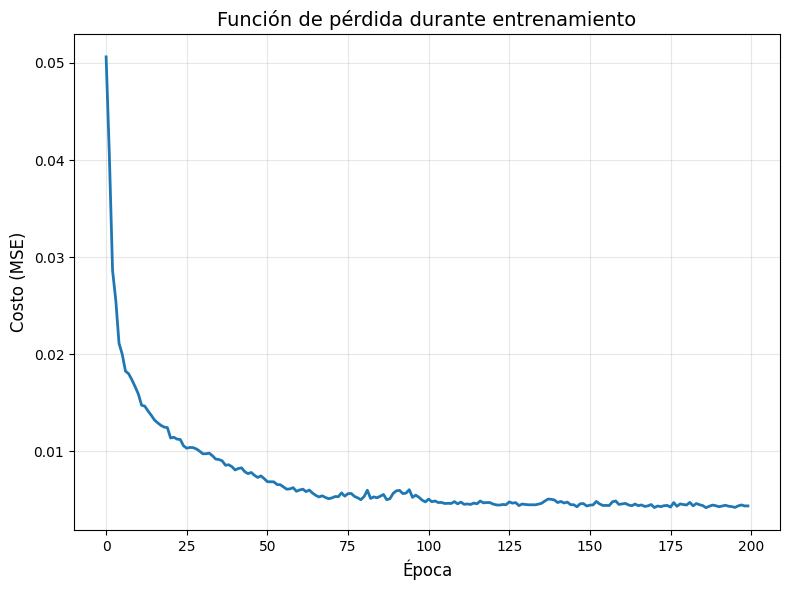

In [33]:

modeloGRU = model_gru_adam(
    X_train,
    y_train,
    n_h= 78,                # número de unidades del estado oculto
    learning_rate=0.001,  # tasa de aprendizaje
    mini_batch_size=64,   # tamaño del minibatch (puedes ajustar)
    num_epochs=200,        # número de épocas
    print_cost=True       # mostrar el costo
)


In [34]:
def predict_gru(x, parameters):
    """
    Realiza una sola pasada hacia adelante de la GRU para predecir un valor.

    Argumentos:
    x -- Datos de entrada para la predicción, shape (n_x, m, T_x)
    parameters -- Diccionario de Python con los parámetros entrenados (Wf, bf, Wi, bi, ...)

    Retorna:
    y_pred -- La predicción del modelo.
    """
    # Extraer dimensiones de la entrada
    n_x, m, T_x = x.shape
    n_y, n_h = parameters["Wy"].shape

    # Inicializar estados ocultos y de celda
    h_next = np.zeros((n_h, m))

    # Bucle a través del tiempo
    for t in range(T_x):
        xt = x[:, :, t]
        h_next, _ = gru_cell_forward(xt, h_next, parameters)
    y_pred = np.dot(parameters['Wy'], h_next) + parameters['by']
    return y_pred

In [35]:
# Tomamos la última ventana de datos conocida del conjunto de prueba
current_window = X_test[:, -1:, :]

# Lista para guardar las predicciones
future_GRU_predictions_scaled = []

# Bucle para predecir 12 pasos hacia adelante
for i in range(12):
    # Hacer la predicción
    next_step_pred_scaled = predict_gru(current_window, modeloGRU)

    # Guardar la predicción
    future_GRU_predictions_scaled.append(next_step_pred_scaled.flatten()[0])

    # Actualizar la ventana: eliminar el valor más antiguo y añadir la nueva predicción
    # El reshape es crucial para mantener la forma (1, 1, T_x)
    new_window_values = np.append(current_window.flatten()[1:], next_step_pred_scaled.flatten())
    current_window = new_window_values.reshape(1, 1, n_steps_in)

# 4. Des-normalizar las predicciones para verlas en la escala original
future_GRU_predictions = scaler.inverse_transform(np.array(future_GRU_predictions_scaled).reshape(-1, 1))

print("Predicciones de inflación para los próximos 12 meses:")
print(future_GRU_predictions.flatten())

Predicciones de inflación para los próximos 12 meses:
[0.05207358 0.05285158 0.05342615 0.05387003 0.05431491 0.05491417
 0.0557958  0.05696586 0.05841377 0.06006178 0.061772   0.06349684]


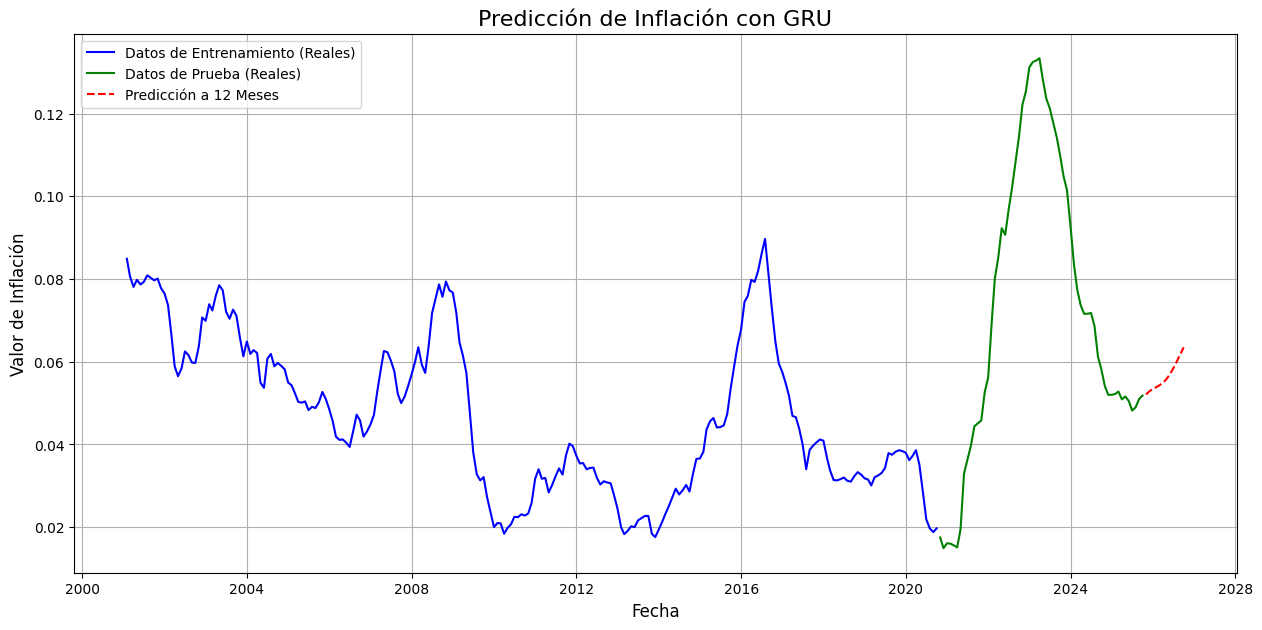

In [36]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=13, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, future_GRU_predictions.flatten(), label='Predicción a 12 Meses', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con GRU', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Implementación con Keras

In [37]:
modeloGRU_Keras = Sequential()
modeloGRU_Keras.add(LSTM(units=78, input_shape=(X_train.shape[1], 1)))
modeloGRU_Keras.add(Dense(1))

modeloGRU_Keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
historyGRU = modeloGRU_Keras.fit(X_train_keras, y_train_keras, epochs=200, batch_size=64, verbose=1)

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.5629
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.3801
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2402
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1736
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1818
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1477
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1441
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1364
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1325
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1155
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1034
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1012
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0957
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0870
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0889
Epoch 16/200
4/4 ━━━━━━━━━━━━━

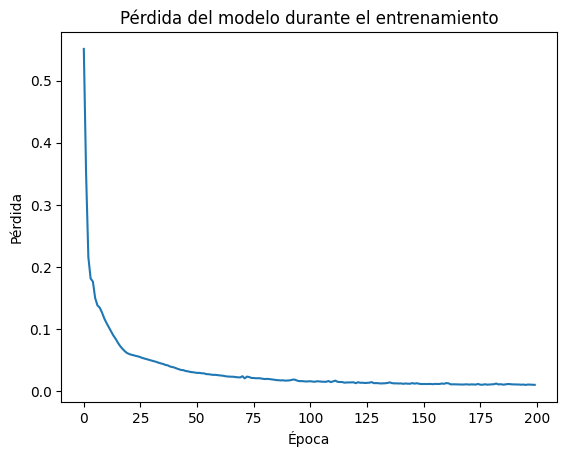

In [38]:
# Graficar la función de pérdida
plt.plot(historyGRU.history['loss'])
plt.title('Pérdida del modelo durante el entrenamiento')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()

In [49]:
# Predicción para el próximo año
seq_lenght = 12 # This should be n_steps_in, which is 12

# Take the last sequence from the scaled data for the initial prediction
current_window_keras = inflation_scaled[-n_steps_in:].reshape(1, n_steps_in, 1)

# List to store the 12-month predictions
future_GRU_keras_predictions_scaled = []

for _ in range(12):
    # Make a prediction for the next step
    next_step_pred_scaled = modeloGRU_Keras.predict(current_window_keras, verbose=0)

    # Store the prediction
    future_GRU_keras_predictions_scaled.append(next_step_pred_scaled[0, 0])

    # Update the window: remove the oldest value and add the new prediction
    # Ensure current_window_keras remains (1, n_steps_in, 1)
    new_window_values = np.append(current_window_keras.flatten()[1:], next_step_pred_scaled.flatten())
    current_window_keras = new_window_values.reshape(1, n_steps_in, 1)

# Denormalize all 12 predictions
future_GRU_keras = scaler.inverse_transform(np.array(future_GRU_keras_predictions_scaled).reshape(-1, 1))

print("Predicciones de inflación para los próximos 12 meses con Keras:")
print(future_GRU_keras.flatten())

Predicciones de inflación para los próximos 12 meses con Keras:
[0.05227803 0.05275952 0.05336394 0.05409845 0.05495141 0.05592499
 0.05699167 0.05815671 0.05939803 0.06065302 0.06189254 0.06310667]


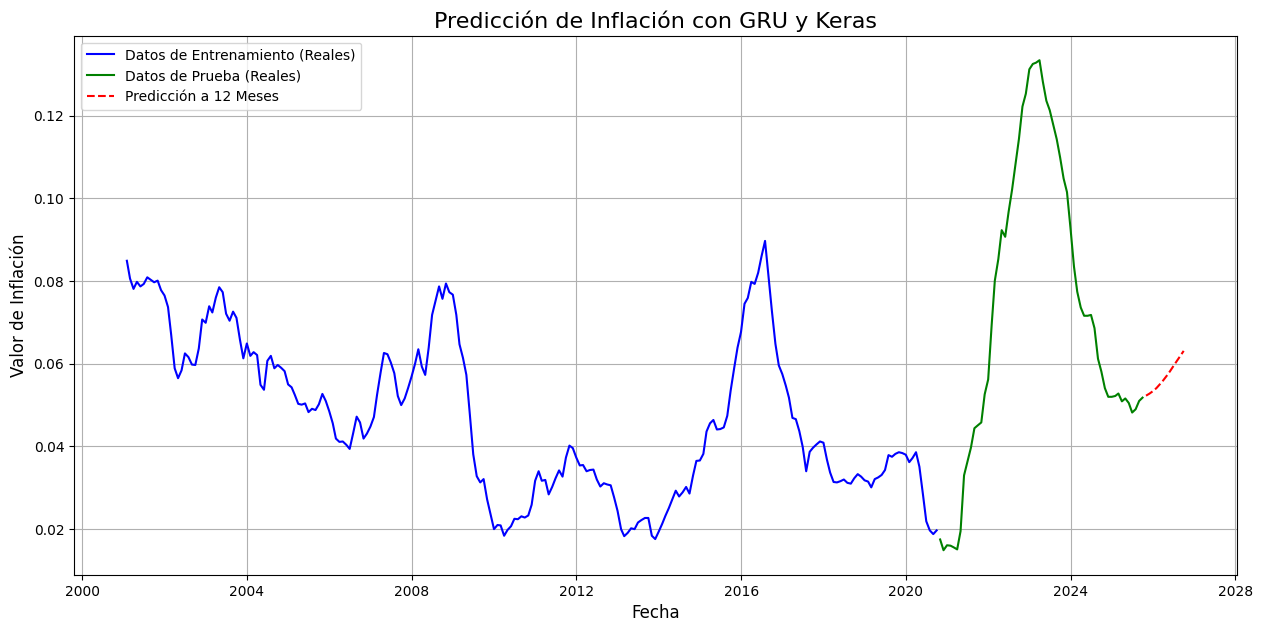

In [50]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=13, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, future_GRU_keras.flatten(), label='Predicción a 12 Meses', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con GRU y Keras', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [51]:
import numpy as np

# Tomamos la última ventana de datos conocida del conjunto de prueba
current_window = X_test[:, -1:, :]

# Lista para guardar las predicciones
future_LSTM_predictions_scaled = []

# Bucle para predecir 24 pasos hacia adelante
for i in range(24):
    # Hacer la predicción
    next_step_pred_scaled = predict_lstm(current_window, modeloLSTM)

    # Guardar la predicción
    future_LSTM_predictions_scaled.append(next_step_pred_scaled.flatten()[0])

    # Actualizar la ventana: eliminar el valor más antiguo y añadir la nueva predicción
    # El reshape es crucial para mantener la forma (1, 1, T_x)
    new_window_values = np.append(current_window.flatten()[1:], next_step_pred_scaled.flatten())
    current_window = new_window_values.reshape(1, 1, n_steps_in)

# 4. Des-normalizar las predicciones para verlas en la escala original
future_LSTM_predictions = scaler.inverse_transform(np.array(future_LSTM_predictions_scaled).reshape(-1, 1))

print("Predicciones de inflación para los próximos 24 meses:")
print(future_LSTM_predictions.flatten())

Predicciones de inflación para los próximos 24 meses:
[0.05198741 0.05274309 0.05325141 0.05371414 0.05426542 0.0549928
 0.05594355 0.05709669 0.05843853 0.05993749 0.06157044 0.0633656
 0.06535747 0.06755474 0.06992088 0.0723482  0.07462458 0.07640777
 0.07725563 0.07676442 0.0747757  0.07150379 0.06747195 0.06329657]


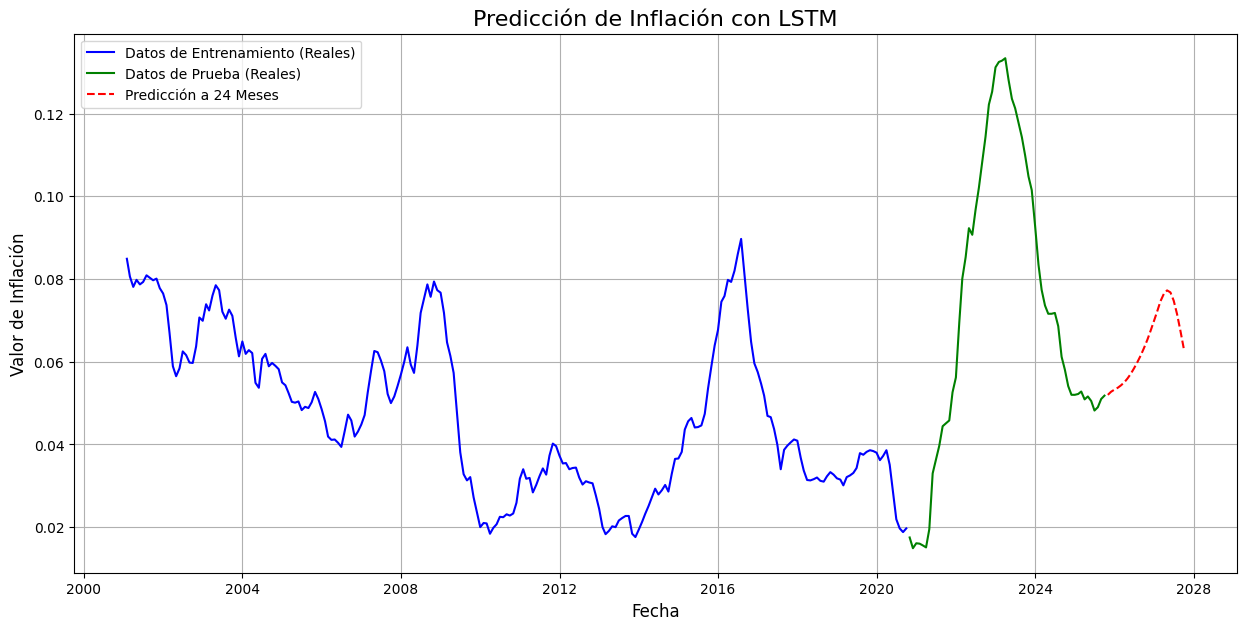

In [52]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:] # Changed periods to 25 for 24 predictions
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, future_LSTM_predictions.flatten(), label='Predicción a 24 Meses', color='red', linestyle='--') # Changed label

# Estilo del gráfico
plt.title('Predicción de Inflación con LSTM', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# Predicción para el próximo año
seq_lenght = 12 # This should be n_steps_in, which is 12

# Take the last sequence from the scaled data for the initial prediction
current_window_keras = inflation_scaled[-n_steps_in:].reshape(1, n_steps_in, 1)

# List to store the 12-month predictions
future_LSTM_keras_predictions_scaled = []

for _ in range(24):
    # Make a prediction for the next step
    next_step_pred_scaled = modeloLSTM_Keras.predict(current_window_keras, verbose=0)

    # Store the prediction
    future_LSTM_keras_predictions_scaled.append(next_step_pred_scaled[0, 0])

    # Update the window: remove the oldest value and add the new prediction
    # Ensure current_window_keras remains (1, n_steps_in, 1)
    new_window_values = np.append(current_window_keras.flatten()[1:], next_step_pred_scaled.flatten())
    current_window_keras = new_window_values.reshape(1, n_steps_in, 1)

# Denormalize all 12 predictions
future_LSTM_keras = scaler.inverse_transform(np.array(future_LSTM_keras_predictions_scaled).reshape(-1, 1))

print("Predicciones de inflación para los próximos 24 meses con Keras:")
print(future_LSTM_keras.flatten())

Predicciones de inflación para los próximos 24 meses con Keras:
[0.05229961 0.05277014 0.0533602  0.05409373 0.05496761 0.05598883
 0.05712501 0.05838968 0.05976547 0.06119021 0.06264556 0.06413776
 0.06564352 0.0671138  0.06847887 0.06965534 0.07055209 0.07107911
 0.07116156 0.07075708 0.06987295 0.06857444 0.06697762 0.06522827]


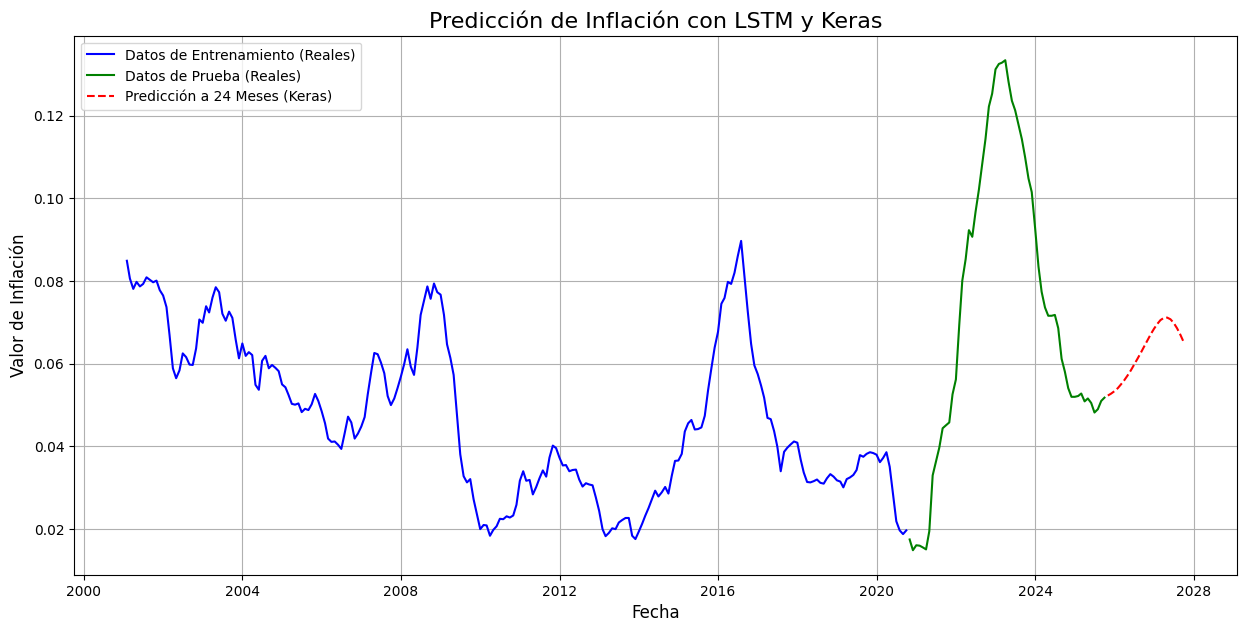

In [54]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, future_LSTM_keras.flatten(), label='Predicción a 24 Meses (Keras)', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con LSTM y Keras', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Tomamos la última ventana de datos conocida del conjunto de prueba
current_window = X_test[:, -1:, :]

# Lista para guardar las predicciones
future_GRU_predictions_scaled = []

# Bucle para predecir 24 pasos hacia adelante
for i in range(24):
    # Hacer la predicción
    next_step_pred_scaled = predict_gru(current_window, modeloGRU)

    # Guardar la predicción
    future_GRU_predictions_scaled.append(next_step_pred_scaled.flatten()[0])

    # Actualizar la ventana: eliminar el valor más antiguo y añadir la nueva predicción
    # El reshape es crucial para mantener la forma (1, 1, T_x)
    new_window_values = np.append(current_window.flatten()[1:], next_step_pred_scaled.flatten())
    current_window = new_window_values.reshape(1, 1, n_steps_in)

# 4. Des-normalizar las predicciones para verlas en la escala original
future_GRU_predictions = scaler.inverse_transform(np.array(future_GRU_predictions_scaled).reshape(-1, 1))

print("Predicciones de inflación para los próximos 24 meses:")
print(future_GRU_predictions.flatten())

Predicciones de inflación para los próximos 24 meses:
[0.05207358 0.05285158 0.05342615 0.05387003 0.05431491 0.05491417
 0.0557958  0.05696586 0.05841377 0.06006178 0.061772   0.06349684
 0.06528082 0.06716906 0.06915966 0.07116604 0.0730082  0.07443617
 0.07517696 0.07499344 0.07374535 0.0714513  0.06832865 0.06477128]


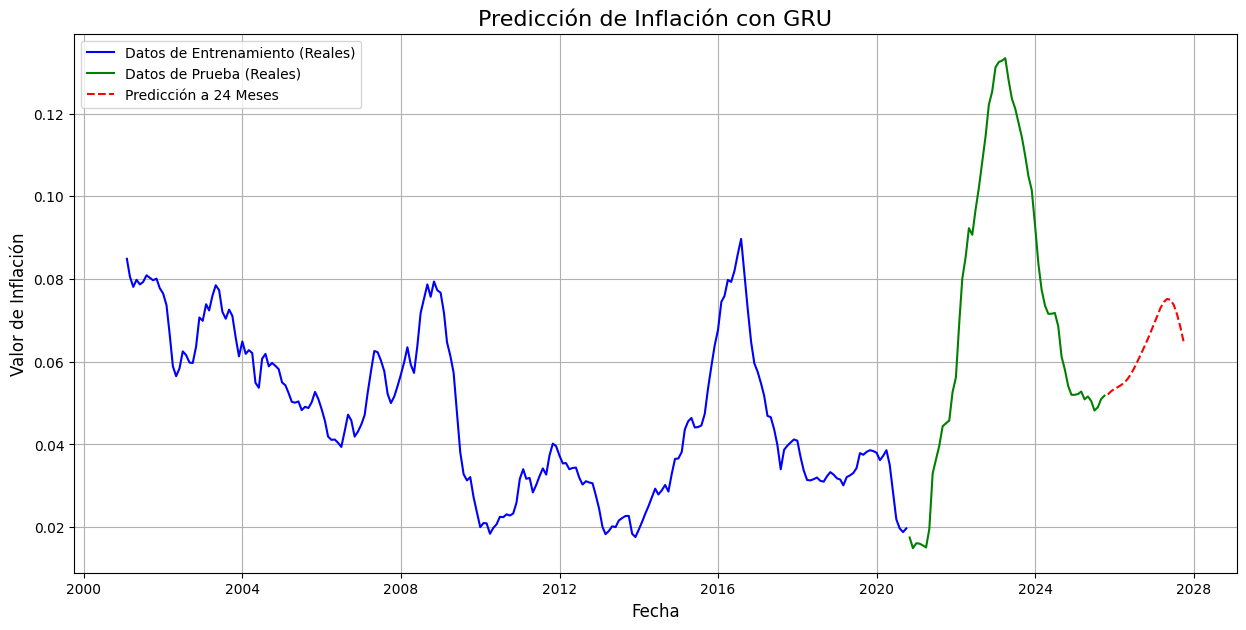

In [56]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, future_GRU_predictions.flatten(), label='Predicción a 24 Meses', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con GRU', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Actualizar predicciones GRU (Keras)

In [57]:
# Predicción para el próximo año
seq_lenght = 12 # This should be n_steps_in, which is 12

# Take the last sequence from the scaled data for the initial prediction
current_window_keras = inflation_scaled[-n_steps_in:].reshape(1, n_steps_in, 1)

# List to store the 12-month predictions
future_GRU_keras_predictions_scaled = []

for _ in range(24):
    # Make a prediction for the next step
    next_step_pred_scaled = modeloGRU_Keras.predict(current_window_keras, verbose=0)

    # Store the prediction
    future_GRU_keras_predictions_scaled.append(next_step_pred_scaled[0, 0])

    # Update the window: remove the oldest value and add the new prediction
    # Ensure current_window_keras remains (1, n_steps_in, 1)
    new_window_values = np.append(current_window_keras.flatten()[1:], next_step_pred_scaled.flatten())
    current_window_keras = new_window_values.reshape(1, n_steps_in, 1)

# Denormalize all 12 predictions
future_GRU_keras = scaler.inverse_transform(np.array(future_GRU_keras_predictions_scaled).reshape(-1, 1))

print("Predicciones de inflación para los próximos 24 meses con Keras:")
print(future_GRU_keras.flatten())

Predicciones de inflación para los próximos 24 meses con Keras:
[0.05227803 0.05275952 0.05336394 0.05409845 0.05495141 0.05592499
 0.05699167 0.05815671 0.05939803 0.06065302 0.06189254 0.06310667
 0.064262   0.06530734 0.06618339 0.06683218 0.06720461 0.06726724
 0.06700864 0.06644282 0.06560936 0.064569   0.06339496 0.06216273]


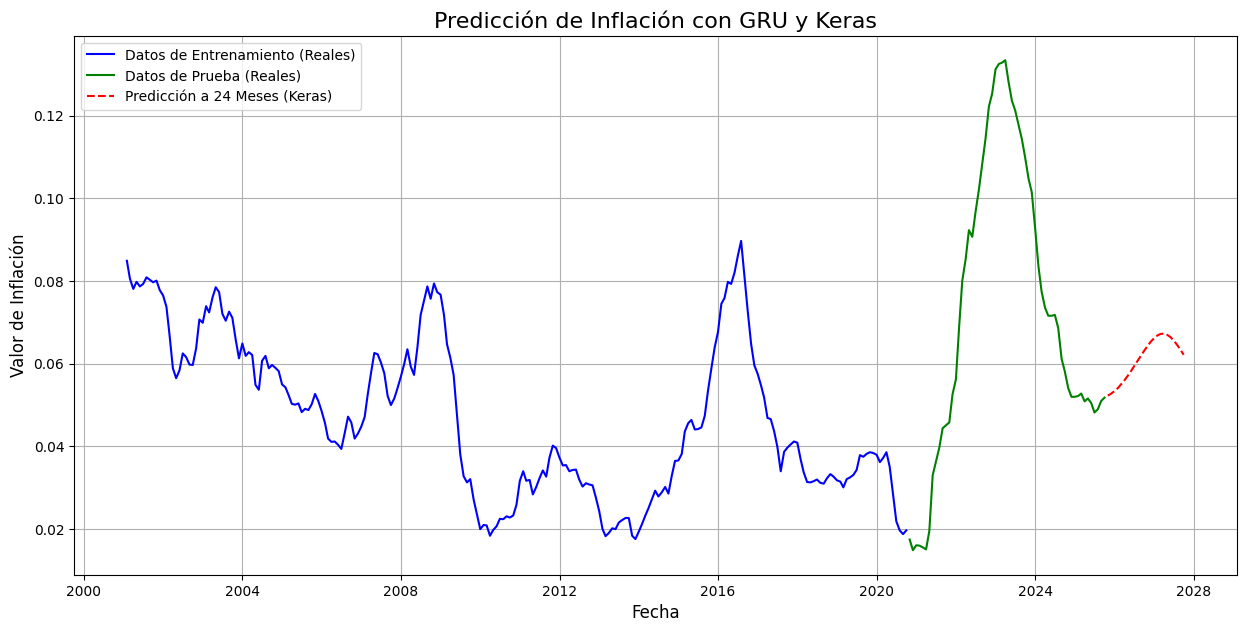

In [58]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, future_GRU_keras.flatten(), label='Predicción a 24 Meses (Keras)', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con GRU y Keras', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [67]:
m_test_lstm = X_test.shape[1]
h0_test_lstm = np.zeros((modeloLSTM['Wf'].shape[0], m_test_lstm))

# Realizar predicciones en el conjunto de prueba con el modelo LSTM implementado
_, y_pred_test_lstm_scaled, _, _ = lstm_forward(X_test, h0_test_lstm, modeloLSTM)

# Des-normalizar las predicciones del conjunto de prueba
y_pred_test_lstm_actual = scaler.inverse_transform(y_pred_test_lstm_scaled.reshape(-1, 1))

# Concatenar las predicciones del conjunto de prueba con las futuras
combined_LSTM_predictions = np.concatenate((y_pred_test_lstm_actual, future_LSTM_predictions))


In [68]:
# Realizar predicciones en el conjunto de prueba con el modelo LSTM de Keras
y_pred_test_lstm_keras_scaled = modeloLSTM_Keras.predict(X_test_keras, verbose=0)

# Des-normalizar las predicciones del conjunto de prueba
y_pred_test_lstm_keras_actual = scaler.inverse_transform(y_pred_test_lstm_keras_scaled.reshape(-1, 1))

# Concatenar las predicciones del conjunto de prueba con las futuras
combined_LSTM_keras_predictions = np.concatenate((y_pred_test_lstm_keras_actual, future_LSTM_keras))


In [69]:
m_test_gru = X_test.shape[1]
h0_test_gru = np.zeros((modeloGRU['Wu'].shape[0], m_test_gru))

# Realizar predicciones en el conjunto de prueba con el modelo GRU implementado
_, y_pred_test_gru_scaled, _ = gru_forward(X_test, h0_test_gru, modeloGRU)

# Des-normalizar las predicciones del conjunto de prueba
y_pred_test_gru_actual = scaler.inverse_transform(y_pred_test_gru_scaled.reshape(-1, 1))

# Concatenar las predicciones del conjunto de prueba con las futuras
combined_GRU_predictions = np.concatenate((y_pred_test_gru_actual, future_GRU_predictions))


In [70]:
# Realizar predicciones en el conjunto de prueba con el modelo GRU de Keras
y_pred_test_gru_keras_scaled = modeloGRU_Keras.predict(X_test_keras, verbose=0)

# Des-normalizar las predicciones del conjunto de prueba
y_pred_test_gru_keras_actual = scaler.inverse_transform(y_pred_test_gru_keras_scaled.reshape(-1, 1))

# Concatenar las predicciones del conjunto de prueba con las futuras
combined_GRU_keras_predictions = np.concatenate((y_pred_test_gru_keras_actual, future_GRU_keras))


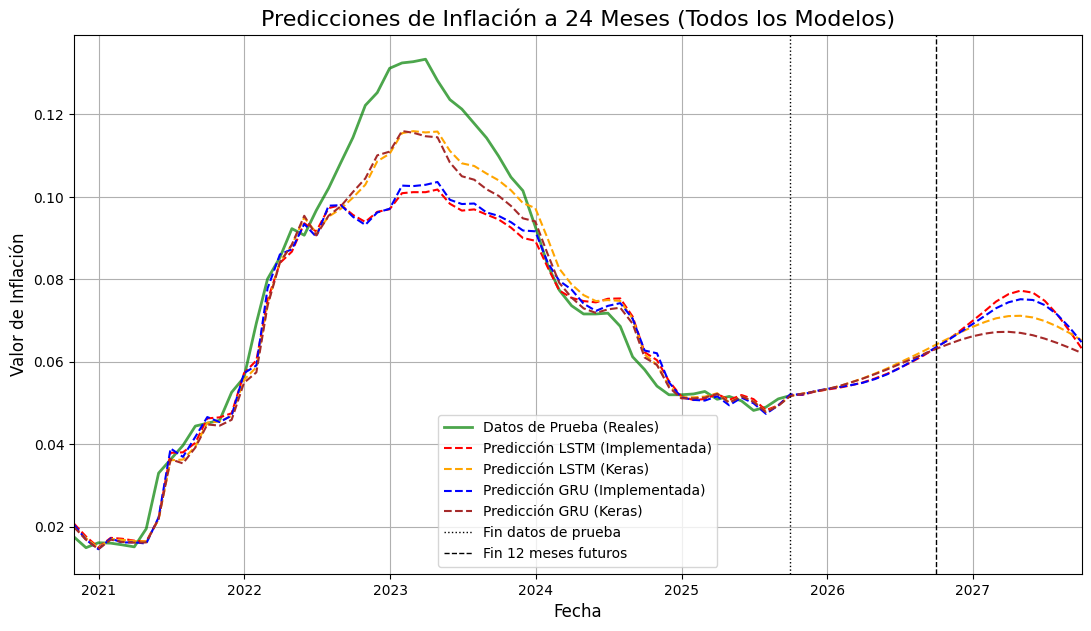

In [77]:
# Des-normalizar los datos para la gráfica (ya realizado anteriormente)
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]

# Crear fechas para las predicciones combinadas (test_dates + future_dates)
combined_prediction_dates = pd.date_range(start=test_dates[0], periods=len(y_test_keras) + 24, freq='ME')

# 1. Create a new figure with a specified size for the plot
plt.figure(figsize=(13, 7))

# 3. Plot the actual test data - this will be used for comparison, but the predictions will cover this range
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green',linewidth=2, alpha=0.7)

# 4. Plot the 24-month predictions from the implemented LSTM model (combined with test predictions)
plt.plot(combined_prediction_dates, combined_LSTM_predictions.flatten(), label='Predicción LSTM (Implementada)', color='red', linestyle='--')

# 5. Plot the 24-month predictions from the Keras LSTM model (combined with test predictions)
plt.plot(combined_prediction_dates, combined_LSTM_keras_predictions.flatten(), label='Predicción LSTM (Keras)', color='orange', linestyle='--')

# 6. Plot the 24-month predictions from the implemented GRU model (combined with test predictions)
plt.plot(combined_prediction_dates, combined_GRU_predictions.flatten(), label='Predicción GRU (Implementada)', color='blue', linestyle='--')

# 7. Plot the 24-month predictions from the Keras GRU model (combined with test predictions)
plt.plot(combined_prediction_dates, combined_GRU_keras_predictions.flatten(), label='Predicción GRU (Keras)', color='brown', linestyle='--')

# 8. Add a vertical dashed gray line at the end of the test data, marking the start of future predictions
# This will be `test_dates[-1]`
plt.axvline(x=test_dates[-1], color='black', linestyle=':', linewidth=1, label='Fin datos de prueba')

# Add another vertical dashed gray line after the first 12 months of *future* predictions
# This means 12 months after the end of test data. The index will be len(y_test_keras) + 11 (0-indexed for 12 months into future)
plt.axvline(x=combined_prediction_dates[len(y_test_keras) + 11], color='black', linestyle='--', linewidth=1, label='Fin 12 meses futuros')

# Ajustar el límite del eje X para que comience en el primer dato del conjunto de prueba
plt.xlim(test_dates[0], combined_prediction_dates[-1])

# 9. Set the title of the plot
plt.title('Predicciones de Inflación a 24 Meses (Todos los Modelos)', fontsize=16)

# 10. Label the x-axis and y-axis
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)

# 11. Display the legend
plt.legend()

# 12. Add a grid to the plot
plt.grid(True)

#plt.savefig("predicciones3.png")
# 13. Show the plot
plt.show()


## Predicción en intervalos (Opcional)


## Calcular Residuos del Conjunto de Prueba



In [78]:
residuals_lstm = y_test_actual - y_pred_test_lstm_actual
residuals_gru = y_test_actual - y_pred_test_gru_actual

print("Residuals for implemented LSTM model:\n", residuals_lstm[:5])
print("\nResiduals for implemented GRU model:\n", residuals_gru[:5])

Residuals for implemented LSTM model:
 [[-0.00322957]
 [-0.00271117]
 [ 0.00112582]
 [-0.00128766]
 [-0.00147608]]

Residuals for implemented GRU model:
 [[-0.00296567]
 [-0.00194268]
 [ 0.00157095]
 [-0.00115541]
 [-0.00054922]]


In [79]:
import copy

def bootstrap_prediction_intervals(model, parameters, scaler, last_window, n_steps_in, n_steps_out, residuals, n_bootstrap_samples=100, model_type='lstm'):
    """
    Genera predicciones futuras con intervalos de confianza utilizando un método de bootstrap.

    Argumentos:
    model -- La función de predicción del modelo (e.g., predict_lstm o predict_gru).
    parameters -- Diccionario con los parámetros entrenados del modelo.
    scaler -- El objeto StandardScaler utilizado para normalizar los datos.
    last_window -- La última ventana de datos escalados para iniciar la predicción, shape (1, 1, n_steps_in).
    n_steps_in -- Número de pasos de entrada de la ventana (para el reshape).
    n_steps_out -- Número de pasos a predecir (horizonte de predicción).
    residuals -- Residuos del conjunto de prueba (diferencia entre real y predicho), shape (num_residuals, 1).
    n_bootstrap_samples -- Número de muestras de bootstrap a generar.
    model_type -- Tipo de modelo ('lstm' o 'gru') para seleccionar la función de predicción.

    Retorna:
    mean_predictions -- La predicción media desnormalizada para cada paso futuro, shape (n_steps_out, 1).
    lower_bound -- El límite inferior del intervalo de confianza desnormalizado, shape (n_steps_out, 1).
    upper_bound -- El límite superior del intervalo de confianza desnormalizado, shape (n_steps_out, 1).
    """

    all_bootstrap_predictions_scaled = []
    residuals_flat = residuals.flatten()

    for _ in range(n_bootstrap_samples):
        current_window_bootstrap = copy.deepcopy(last_window)
        current_bootstrap_predictions_scaled = []

        for _ in range(n_steps_out):
            # Hacer la predicción base (escalada)
            if model_type == 'lstm':
                next_step_pred_scaled = predict_lstm(current_window_bootstrap, parameters)
            elif model_type == 'gru':
                next_step_pred_scaled = predict_gru(current_window_bootstrap, parameters)
            else:
                raise ValueError("model_type must be 'lstm' or 'gru'")

            # Seleccionar un residuo aleatorio con reemplazo
            random_residual = np.random.choice(residuals_flat)

            # Ajustar la predicción con el residuo
            adjusted_pred_scaled = next_step_pred_scaled.flatten()[0] + random_residual

            current_bootstrap_predictions_scaled.append(adjusted_pred_scaled)

            # Actualizar la ventana para la siguiente predicción
            # Asegurarse de que el new_window_values tenga la forma correcta antes de reshape
            new_window_values = np.append(current_window_bootstrap.flatten()[1:], adjusted_pred_scaled)
            current_window_bootstrap = new_window_values.reshape(1, 1, n_steps_in)

        all_bootstrap_predictions_scaled.append(current_bootstrap_predictions_scaled)

    # Convertir la lista de predicciones bootstrap a un array numpy
    all_bootstrap_predictions_scaled = np.array(all_bootstrap_predictions_scaled)

    # Calcular la media y los percentiles para cada paso de tiempo
    mean_predictions_scaled = np.mean(all_bootstrap_predictions_scaled, axis=0).reshape(-1, 1)
    lower_bound_scaled = np.percentile(all_bootstrap_predictions_scaled, 2.5, axis=0).reshape(-1, 1)
    upper_bound_scaled = np.percentile(all_bootstrap_predictions_scaled, 97.5, axis=0).reshape(-1, 1)

    # Desnormalizar las predicciones
    mean_predictions = scaler.inverse_transform(mean_predictions_scaled)
    lower_bound = scaler.inverse_transform(lower_bound_scaled)
    upper_bound = scaler.inverse_transform(upper_bound_scaled)

    return mean_predictions, lower_bound, upper_bound

print("bootstrap_prediction_intervals function defined.")


bootstrap_prediction_intervals function defined.


## Generar Intervalos de Predicción LSTM



In [80]:
last_window_lstm = X_test[:, -1:, :]

lstm_mean_predictions, lstm_lower_bound, lstm_upper_bound = bootstrap_prediction_intervals(
    model=predict_lstm,
    parameters=modeloLSTM,
    scaler=scaler,
    last_window=last_window_lstm,
    n_steps_in=n_steps_in,
    n_steps_out=24,
    residuals=residuals_lstm,
    n_bootstrap_samples=500,
    model_type='lstm'
)

print("LSTM Mean Predictions (next 24 months):")
print(lstm_mean_predictions.flatten()[:5], "...")
print("\nLSTM Lower Bound (next 24 months):")
print(lstm_lower_bound.flatten()[:5], "...")
print("\nLSTM Upper Bound (next 24 months):")
print(lstm_upper_bound.flatten()[:5], "...")

LSTM Mean Predictions (next 24 months):
[0.05216888 0.05312047 0.05385947 0.05458962 0.05539937] ...

LSTM Lower Bound (next 24 months):
[0.05181743 0.05248596 0.05293874 0.05335824 0.05388316] ...

LSTM Upper Bound (next 24 months):
[0.05285222 0.05430982 0.05535578 0.05643293 0.05761728] ...


## Generar Intervalos de Predicción GRU


In [81]:
last_window_gru = X_test[:, -1:, :]

gru_mean_predictions, gru_lower_bound, gru_upper_bound = bootstrap_prediction_intervals(
    model=predict_gru,
    parameters=modeloGRU,
    scaler=scaler,
    last_window=last_window_gru,
    n_steps_in=n_steps_in,
    n_steps_out=24,
    residuals=residuals_gru,
    n_bootstrap_samples=500,
    model_type='gru'
)

print("GRU Mean Predictions (next 24 months):")
print(gru_mean_predictions.flatten()[:5], "...")
print("\nGRU Lower Bound (next 24 months):")
print(gru_lower_bound.flatten()[:5], "...")
print("\nGRU Upper Bound (next 24 months):")
print(gru_upper_bound.flatten()[:5], "...")

GRU Mean Predictions (next 24 months):
[0.05223385 0.05322805 0.05404488 0.05478157 0.05551431] ...

GRU Lower Bound (next 24 months):
[0.05186666 0.05259803 0.05307471 0.05351404 0.05394228] ...

GRU Upper Bound (next 24 months):
[0.05286541 0.05435167 0.05550025 0.05651334 0.05753435] ...


## Graficar Predicciones LSTM con Intervalos


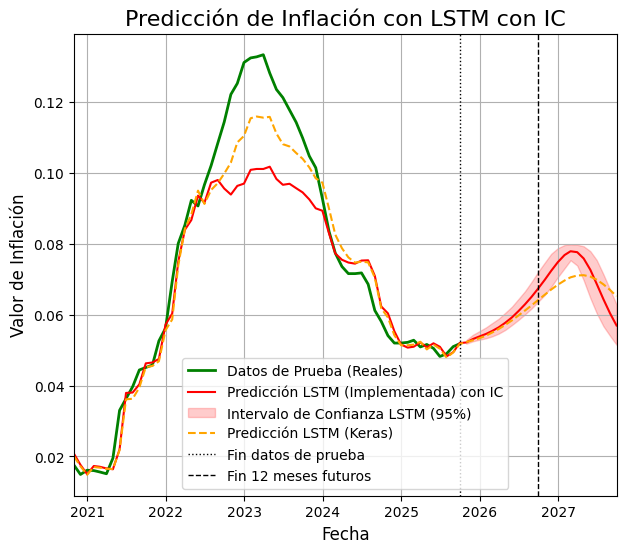

In [93]:
import matplotlib.pyplot as plt

# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]

# Crear fechas para las predicciones combinadas (test_dates + future_dates)
combined_prediction_dates = pd.date_range(start=test_dates[0], periods=len(y_test_keras) + 24, freq='ME')

# Combine test predictions with bootstrapped future mean predictions for LSTM implemented model
combined_lstm_bootstrap_mean_predictions = np.concatenate((y_pred_test_lstm_actual, lstm_mean_predictions))

# 1. Inicializa una figura con plt.figure() y un tamaño apropiado.
plt.figure(figsize=(7, 6))

# 6. Grafica los datos reales de prueba
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green', linewidth=2)

# 7. Grafica la predicción media del modelo LSTM implementado (corregido)
plt.plot(combined_prediction_dates, combined_lstm_bootstrap_mean_predictions.flatten(), label='Predicción LSTM (Implementada) con IC', color='red', linestyle='-')

# 8. Rellena el área entre los límites superior e inferior del intervalo de confianza del LSTM
# The prediction intervals are for the future 24 months, so they start AFTER the test data.
# 'future_dates_only' aligns with the length of 'lstm_lower_bound' and 'lstm_upper_bound'.
future_dates_only = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]

plt.fill_between(future_dates_only, lstm_lower_bound.flatten(), lstm_upper_bound.flatten(), color='red', alpha=0.2, label='Intervalo de Confianza LSTM (95%)')

# 9. Grafica la predicción del modelo LSTM de Keras
plt.plot(combined_prediction_dates, combined_LSTM_keras_predictions.flatten(), label='Predicción LSTM (Keras)', color='orange', linestyle='--')

# 10. Agrega una línea vertical en la última fecha del conjunto de prueba
plt.axvline(x=test_dates[-1], color='black', linestyle=':', linewidth=1, label='Fin datos de prueba')

# 11. Agrega otra línea vertical para marcar el fin de los primeros 12 meses de las predicciones futuras
plt.axvline(x=combined_prediction_dates[len(y_test_keras) + 11], color='black', linestyle='--', linewidth=1, label='Fin 12 meses futuros')

# 12. Ajusta los límites del eje X
plt.xlim(test_dates[0], combined_prediction_dates[-1])

# 13. Añade un título al gráfico, etiquetas a los ejes x e y, una leyenda y una cuadrícula.
plt.title('Predicción de Inflación con LSTM con IC', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
#plt.savefig("lstmIC.png")
plt.show()

## Graficar Predicciones GRU con Intervalos


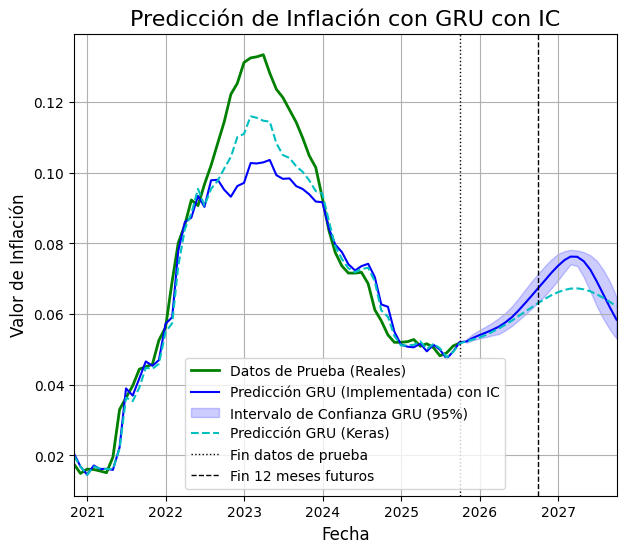

In [92]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]

# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
# This variable is needed for plt.fill_between to align with gru_lower_bound and gru_upper_bound
future_dates_only = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]

# Define el rango de fechas para las predicciones combinadas (test_dates + future_dates)
combined_prediction_dates = pd.date_range(start=test_dates[0], periods=len(y_test_keras) + 24, freq='ME')

# Combina las predicciones del conjunto de prueba para el modelo GRU implementado
# con las predicciones medias futuras bootstrapeadas para crear una serie continua
combined_gru_bootstrap_mean_predictions = np.concatenate((y_pred_test_gru_actual, gru_mean_predictions))

# 6. Inicializa una figura con plt.figure() y un tamaño apropiado.
plt.figure(figsize=(7, 6))

# 7. Grafica los datos reales de prueba
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green', linewidth=2)

# 8. Grafica la predicción media del modelo GRU implementado
plt.plot(combined_prediction_dates, combined_gru_bootstrap_mean_predictions.flatten(), label='Predicción GRU (Implementada) con IC', color='blue', linestyle='-')

# 9. Rellena el área entre los límites superior e inferior del intervalo de confianza del GRU
plt.fill_between(future_dates_only, gru_lower_bound.flatten(), gru_upper_bound.flatten(), color='blue', alpha=0.2, label='Intervalo de Confianza GRU (95%)')

# 10. Grafica la predicción del modelo GRU de Keras
plt.plot(combined_prediction_dates, combined_GRU_keras_predictions.flatten(), label='Predicción GRU (Keras)', color='c', linestyle='--')

# 11. Agrega una línea vertical en la última fecha del conjunto de prueba
plt.axvline(x=test_dates[-1], color='black', linestyle=':', linewidth=1, label='Fin datos de prueba')

# 12. Agrega otra línea vertical para marcar el fin de los primeros 12 meses de las predicciones futuras
plt.axvline(x=combined_prediction_dates[len(y_test_keras) + 11], color='black', linestyle='--', linewidth=1, label='Fin 12 meses futuros')

# 13. Ajusta los límites del eje X
plt.xlim(test_dates[0], combined_prediction_dates[-1])

# 14. Añade un título al gráfico, etiquetas a los ejes x e y, una leyenda y una cuadrícula.
plt.title('Predicción de Inflación con GRU con IC', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
#plt.savefig("gruIC.png")
plt.show()